In [2]:
from Scripts.essentials import *
import h5py

Available computational components
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10636964459489918173
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2051538944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17703721017886334741
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 OEM, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
# Load the data into a dictionary
data_path = "Data/HF2600Sample/"

data = []
data_names = []
for sample in os.listdir(data_path):
    with h5py.File(data_path + sample) as f:
        regions = f["Regions"]
        
        datasets = np.empty((0, 1738))
        for region in list(regions):
            datasets = np.concatenate((datasets, np.nan_to_num(normalize(np.array(regions[region]["Dataset"]).reshape(-1, 1738)))))
            
        data.append(datasets)
        data_names.append(sample)

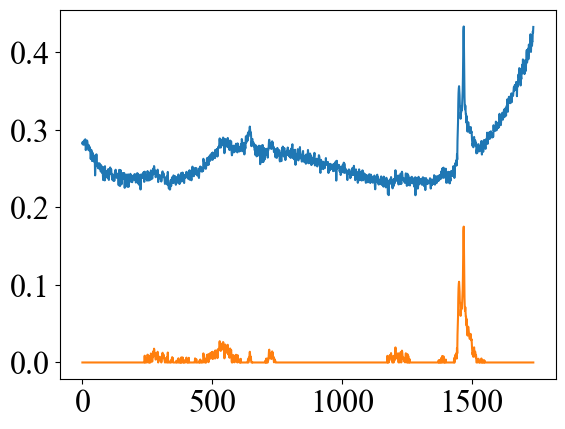

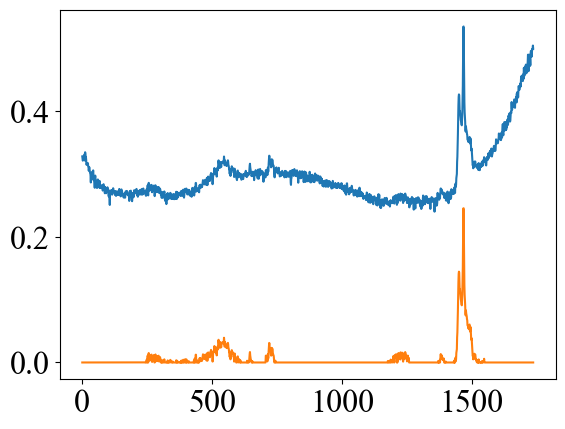

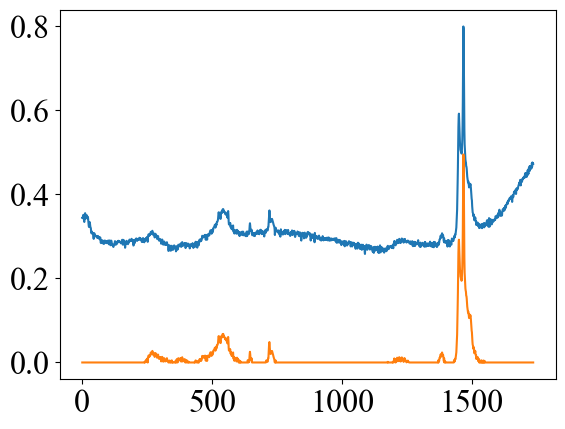

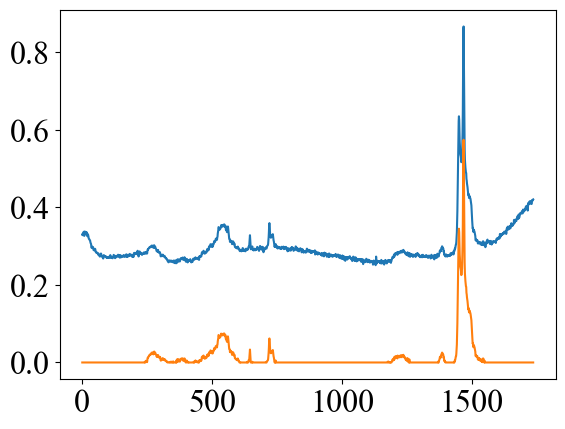

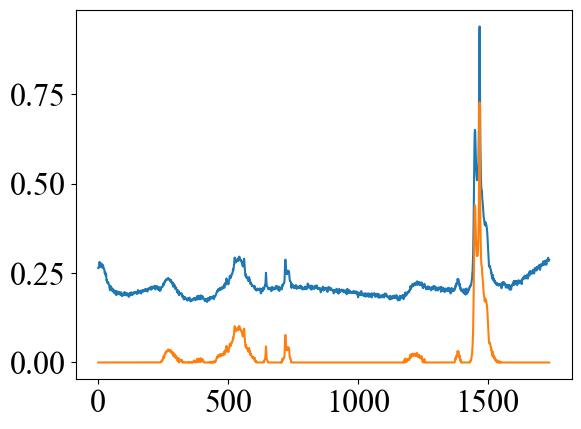

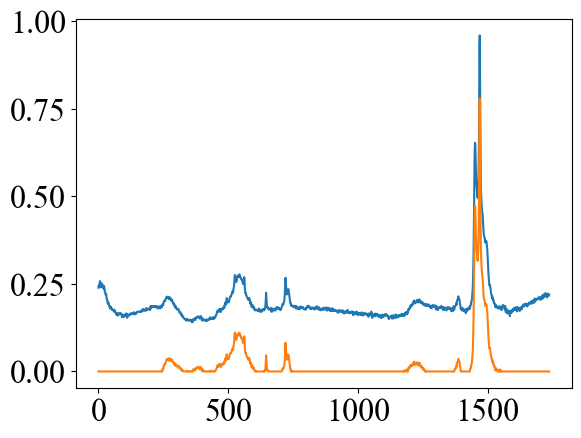

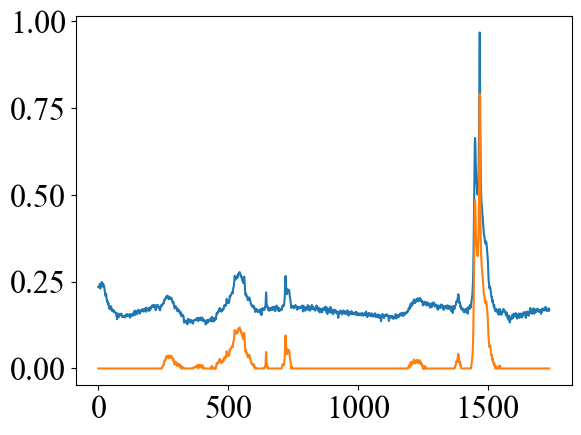

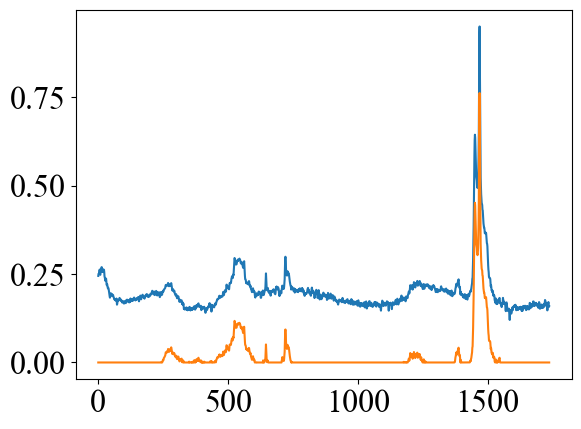

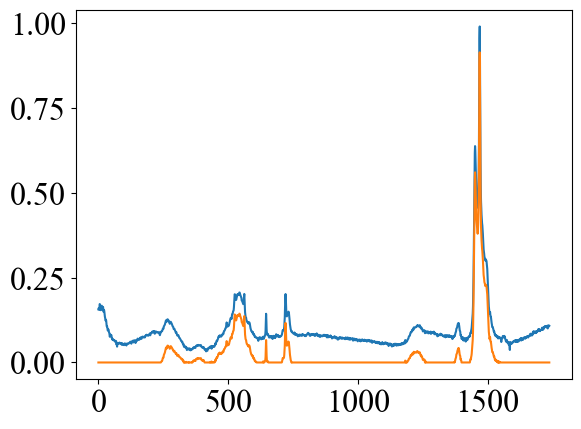

In [12]:
ranges = [[240, 350], [360, 410], [430, 610], [635, 655], [705, 745], [1175, 1260], [1370, 1400], [1430, 1550]]
targets = []
for i in range(len(data)):
    target = np.mean(np.array(np.nan_to_num(data[i])).reshape((-1, 1738)), axis = 0)
    new_target = np.zeros_like(target)
    # Get the peaks
    for r in ranges:
        peak = target[r[0]: r[1] + 1]
    
        
        start = np.median(peak[0:3])
        end = np.median(peak[-3:])
    
        # The baseline at peak location is a linear line between the medians of the left and right ends, estimated by the 10 first and last points
        bl = np.linspace(start, end, r[1] - r[0] + 1, axis = -1)
    
        # Remove the baseline
        new_peak = np.clip(peak - bl, 0, 1)
    
        # Insert the peak
        new_target[r[0]:r[1]+1] = new_peak
    plt.plot(target)
    plt.plot(new_target)
    plt.show()
    
    targets.append(new_target)

In [4]:
ensemble_model = make_ensemble()
ensemble_model.load_weights(filepath= "Models/ensembleModelRes.h5")

standard_model = make_standard()
standard_model.load_weights(filepath = "Models/standardModel.h5")

cascade = tf.keras.models.load_model("Models/unet_three.23-64.96.h5")

In [14]:
ensemble_preds = {}
standard_preds = {}

for d, n in zip(data, data_names):
    print(n)
        
    dn_1 = d[0].reshape((-1, 1738))

    # Normalization
    maxim = np.max(dn_1, axis = 1)
    minim = np.min(dn_1, axis = 1)
    dn_1 = (dn_1 - np.expand_dims(minim, -1)) / np.expand_dims(maxim - minim, -1)
        
    denoised_1 = ensemble_model.predict(np.expand_dims(dn_1, -1))[-1]
    denoised_2 = standard_model.predict(np.expand_dims(dn_1, -1))[-1]
    
    ensemble_preds[n] = denoised_1
    standard_preds[n] = denoised_2


HF2600exp0.005s25um.h5
200/200 [==============================] - 15s 71ms/step
HF2600exp0.01s25um.h5
200/200 [==============================] - 14s 71ms/step
HF2600exp0.05s25um.h5
200/200 [==============================] - 14s 71ms/step
HF2600exp0.1s25um.h5
200/200 [==============================] - 14s 71ms/step
HF2600exp0.25s25um.h5
200/200 [==============================] - 14s 71ms/step
HF2600exp0.5s25um.h5
200/200 [==============================] - 14s 72ms/step
HF2600exp1s25um.h5
200/200 [==============================] - 14s 71ms/step
HF2600exp2s.h5
200/200 [==============================] - 14s 72ms/step
HF2600exp5s.h5
200/200 [==============================] - 14s 71ms/step


In [15]:

casc_preds = {}
for d, n in zip(data, data_names):
    print(n)
        
    dn_1 = d[0].reshape((-1, 1738)) * 1000
        
        # Model is designed for spectrum length 1024, split the spectrum in half 
    denoised_1 = np.squeeze(cascade.predict(np.expand_dims(dn_1[:, :1024], -1))[-1]/1000)
    denoised_2 = np.squeeze(cascade.predict(np.expand_dims(dn_1[:, -1024 :], -1))[-1]/1000)
        
        #Join the predictions in the middle
    denoised = np.hstack((denoised_1[:, :1738 - 1024], denoised_2))
        
    casc_preds[n] = denoised

HF2600exp0.005s25um.h5
200/200 [==============================] - 17s 85ms/step
HF2600exp0.01s25um.h5
200/200 [==============================] - 17s 85ms/step
HF2600exp0.05s25um.h5
200/200 [==============================] - 17s 85ms/step
HF2600exp0.1s25um.h5
200/200 [==============================] - 17s 85ms/step
HF2600exp0.25s25um.h5
200/200 [==============================] - 17s 85ms/step
HF2600exp0.5s25um.h5
200/200 [==============================] - 17s 85ms/step
HF2600exp1s25um.h5
200/200 [==============================] - 17s 85ms/step
HF2600exp2s.h5
200/200 [==============================] - 17s 85ms/step
HF2600exp5s.h5
200/200 [==============================] - 17s 85ms/step


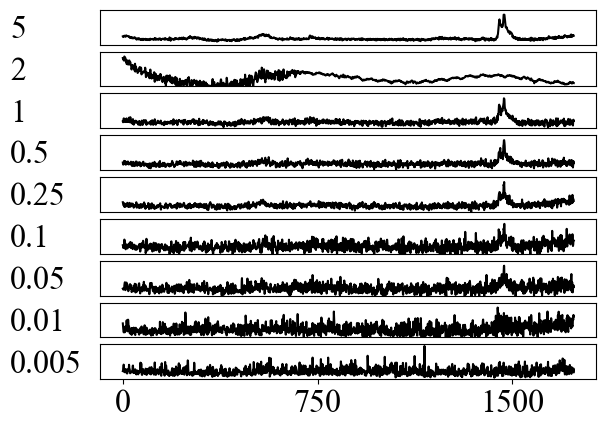

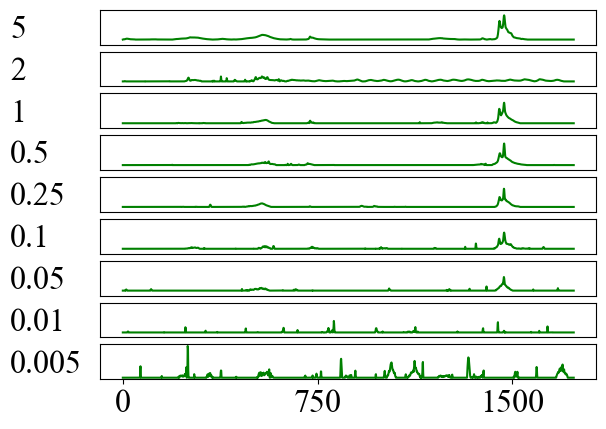

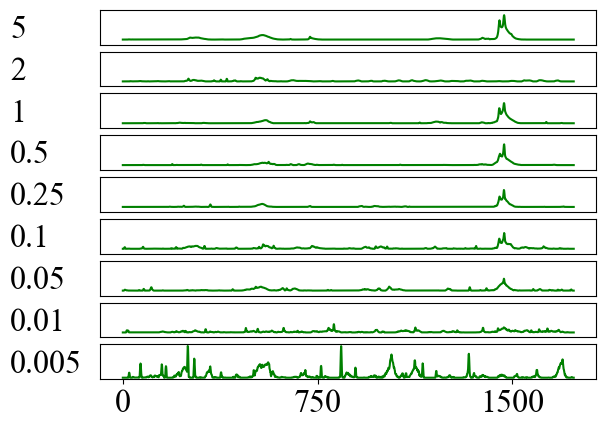

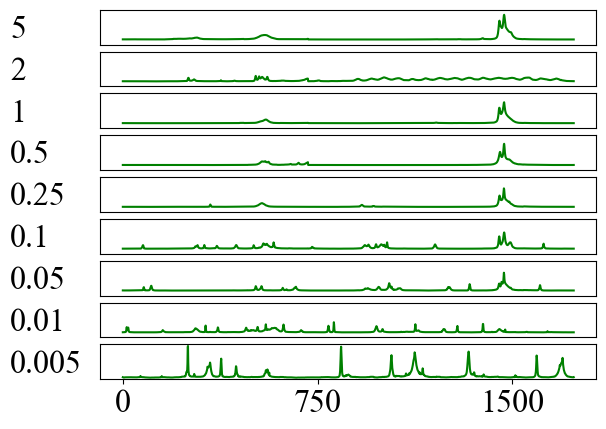

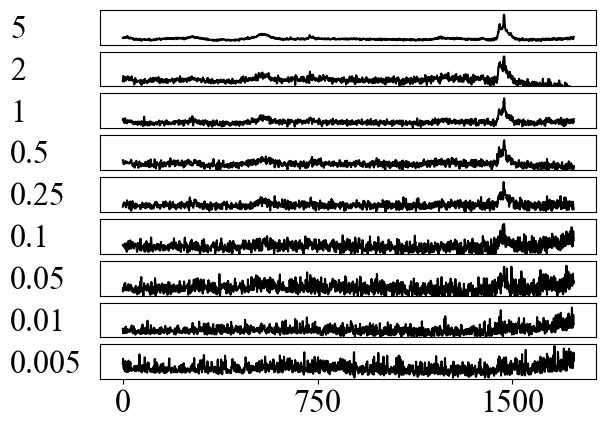

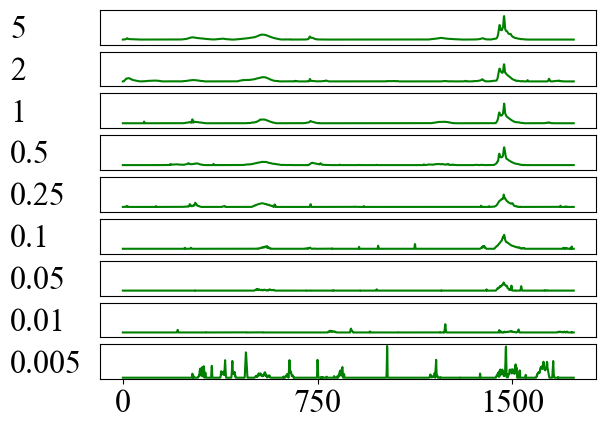

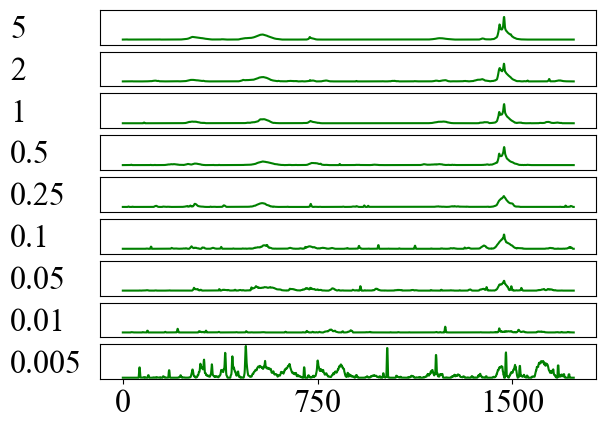

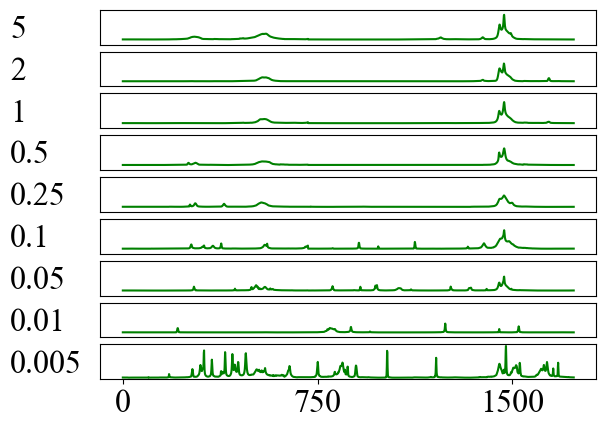

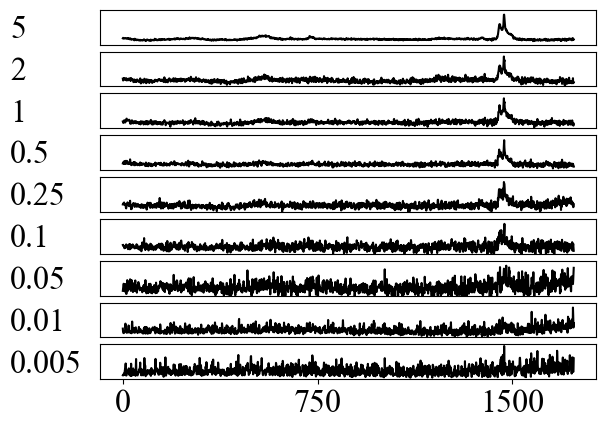

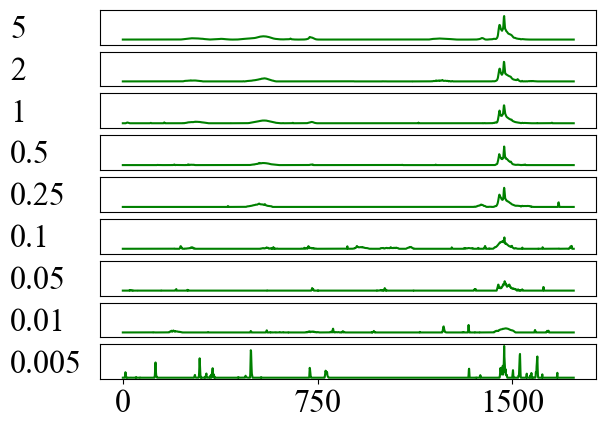

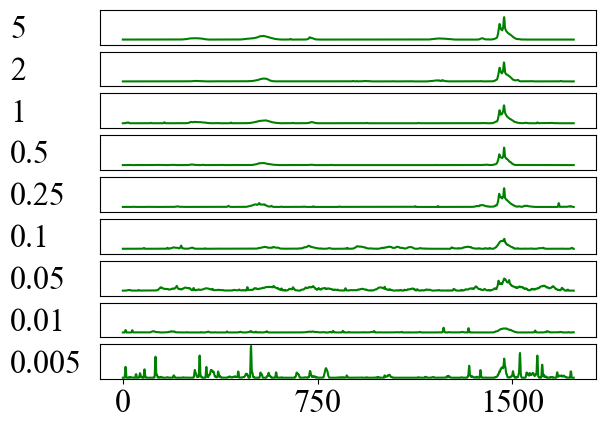

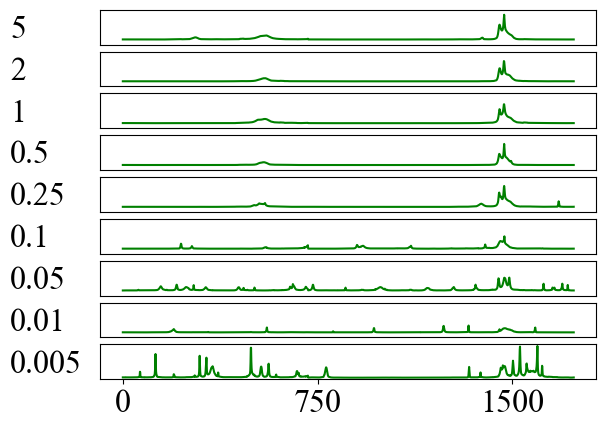

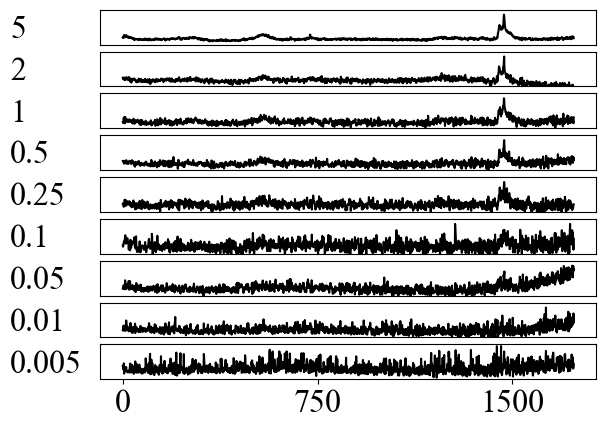

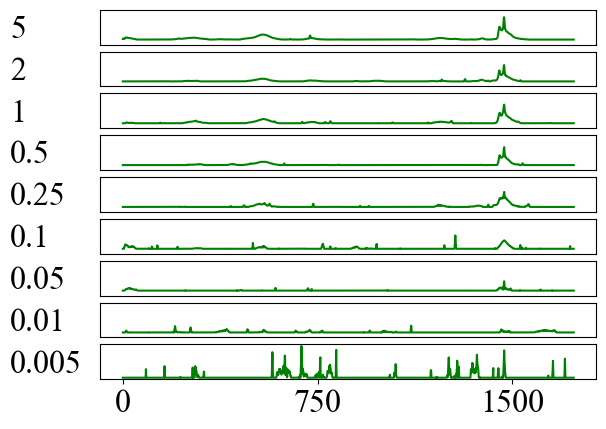

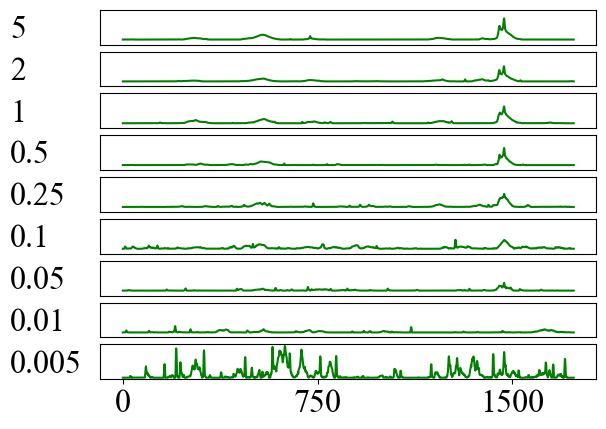

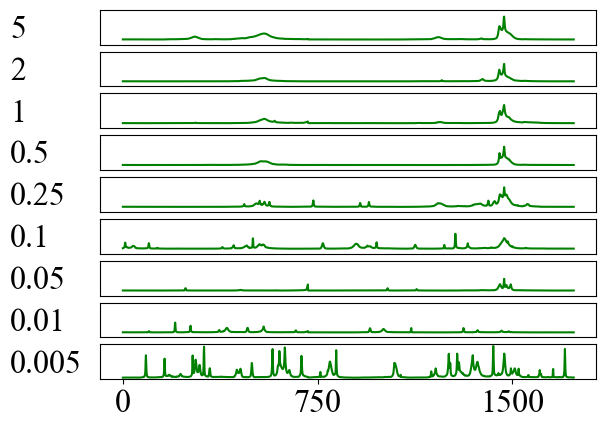

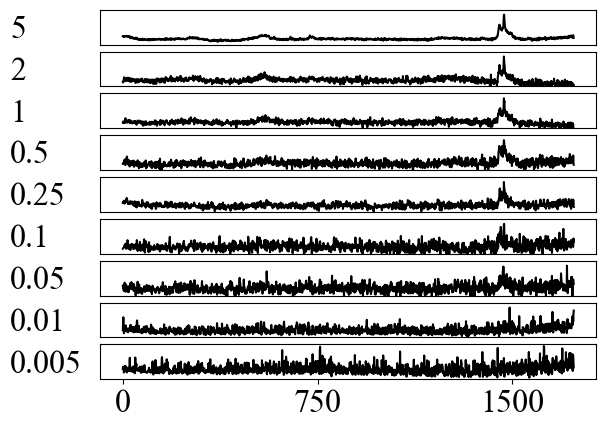

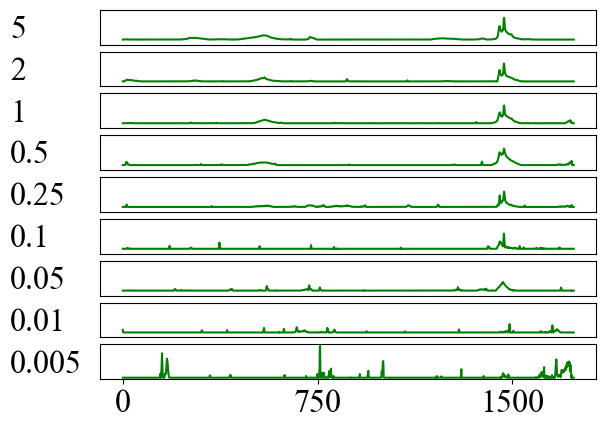

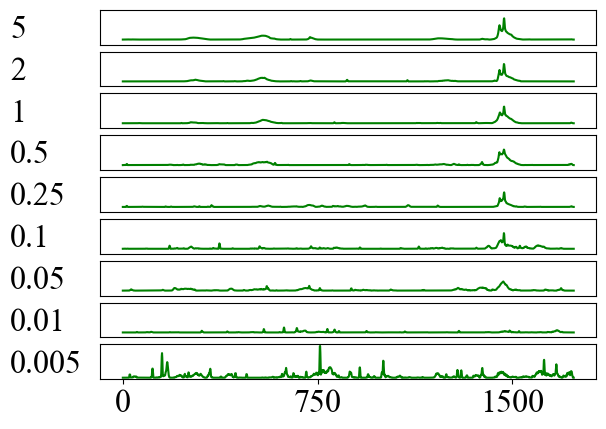

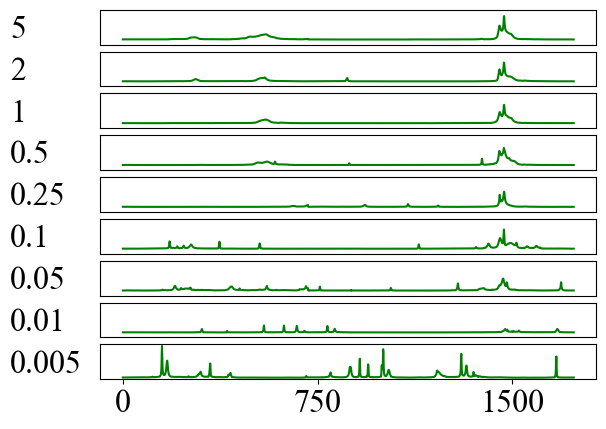

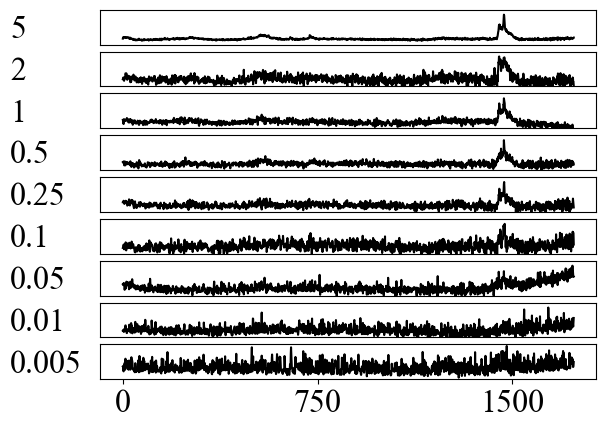

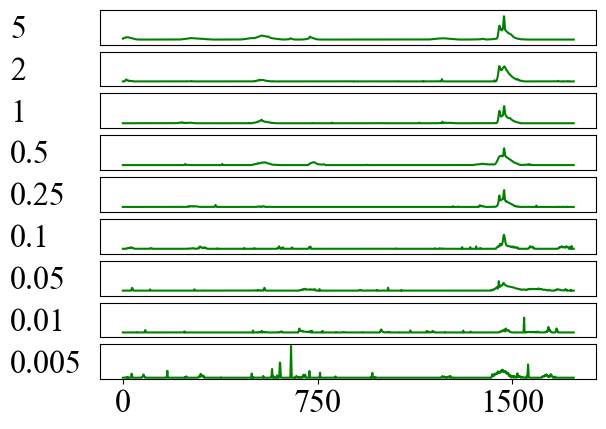

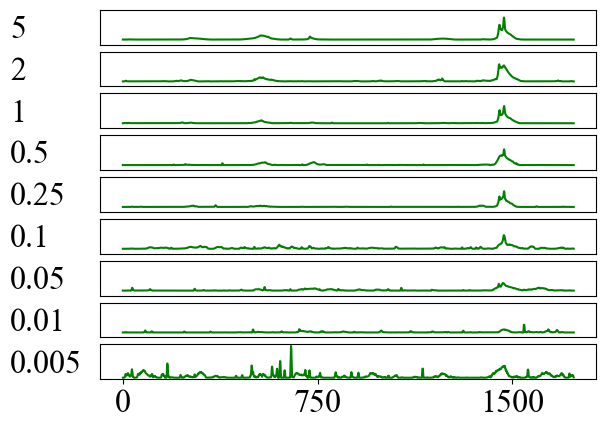

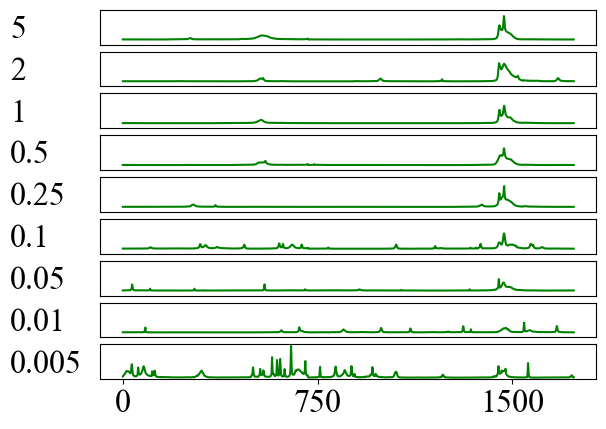

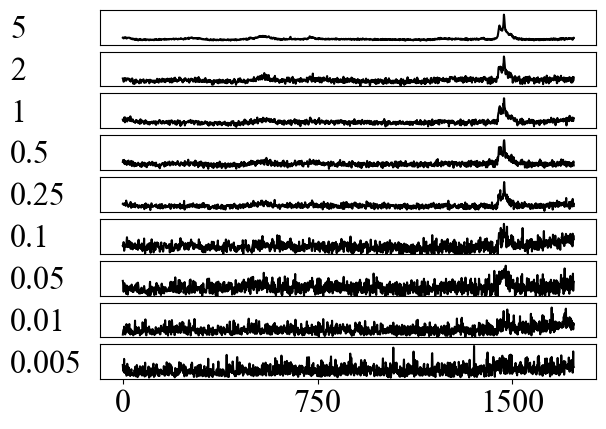

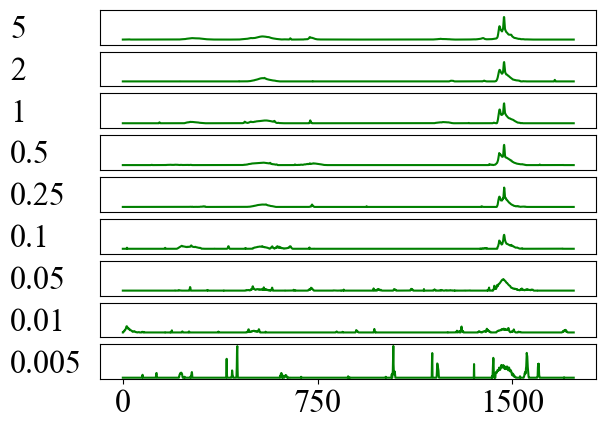

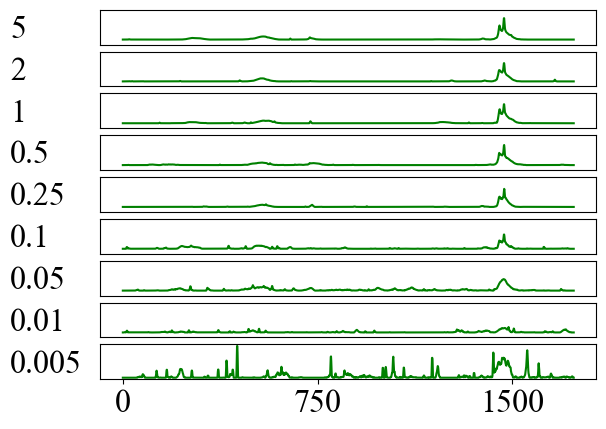

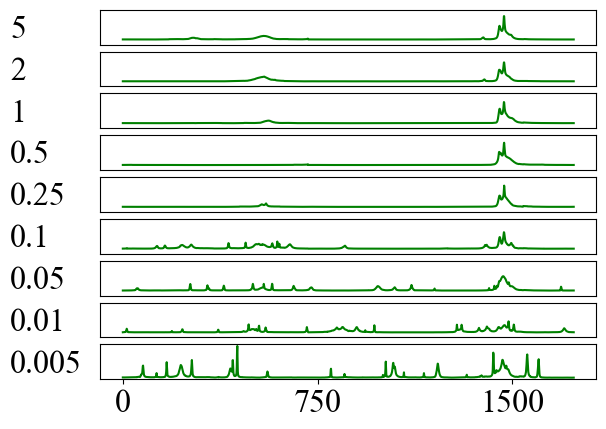

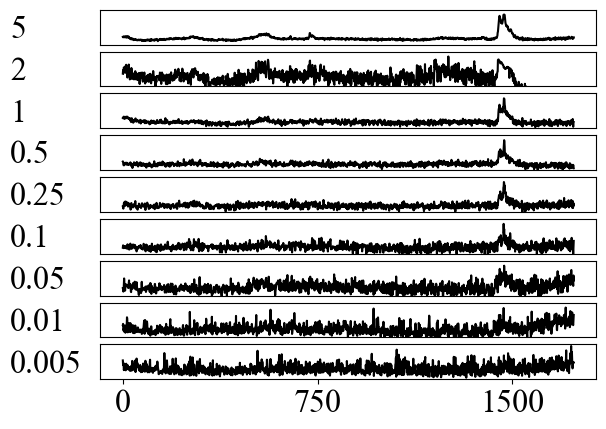

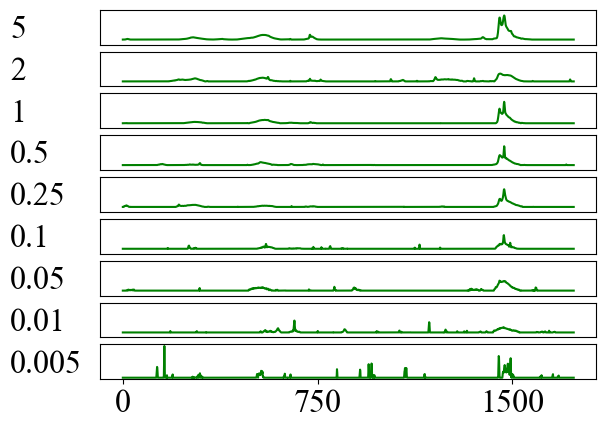

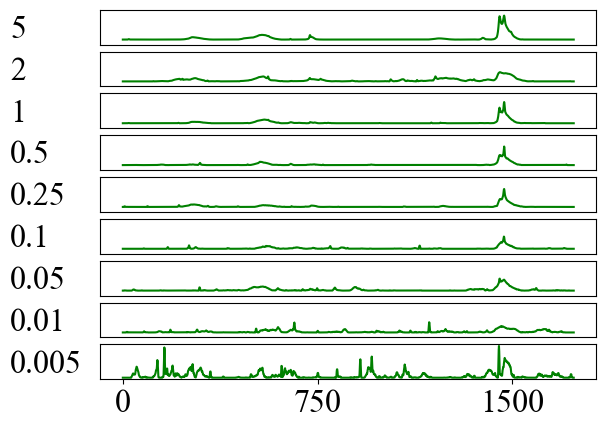

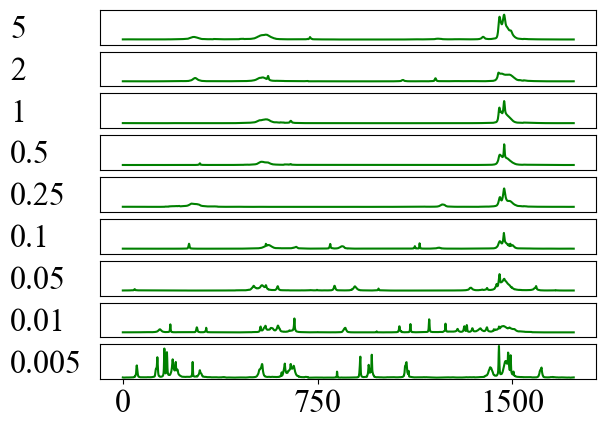

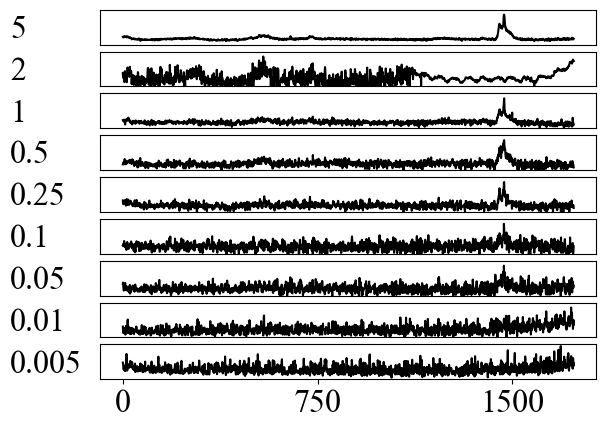

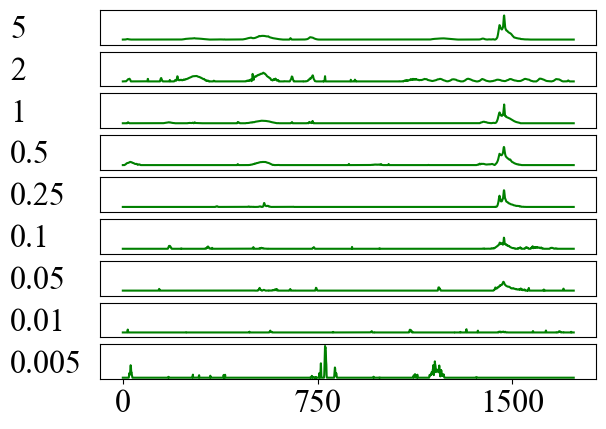

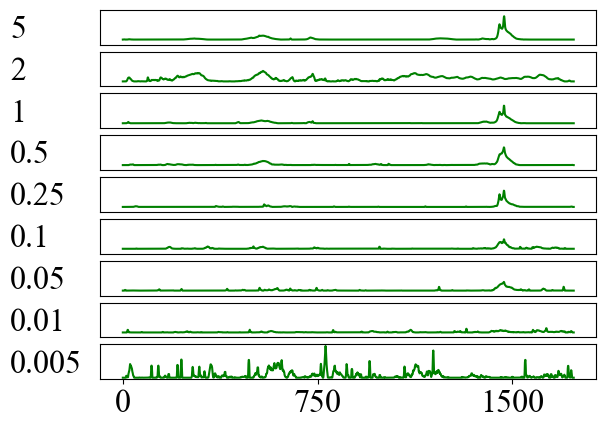

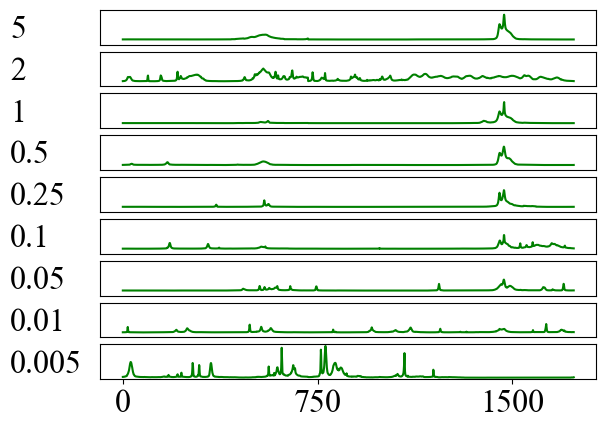

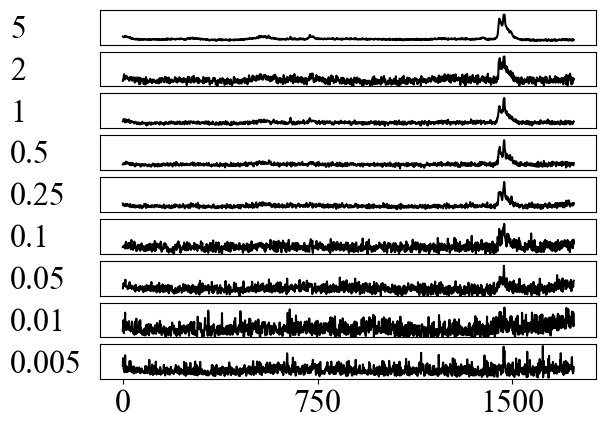

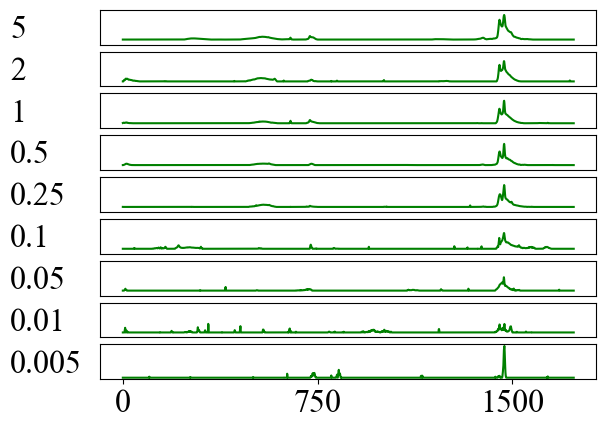

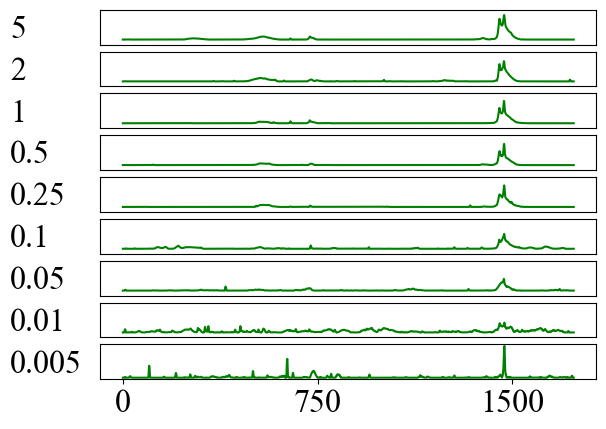

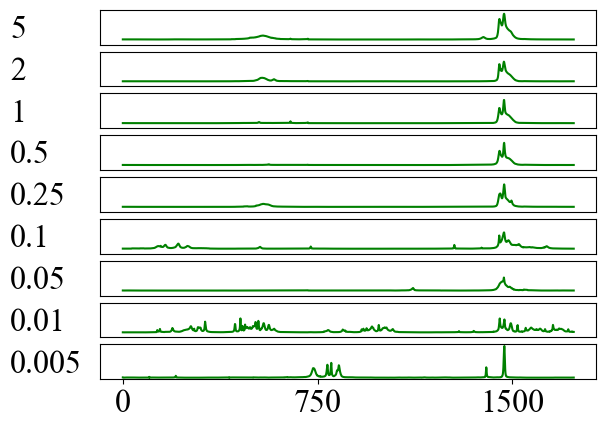

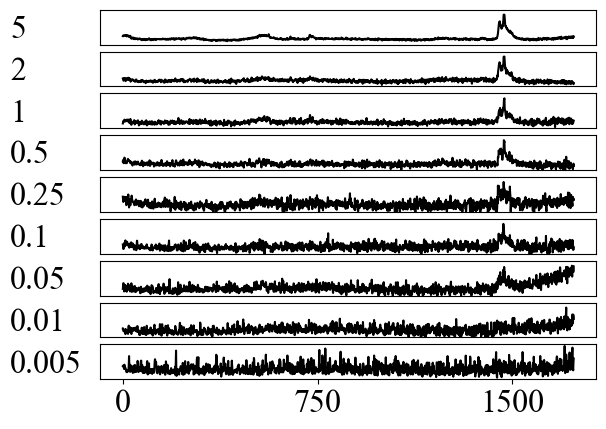

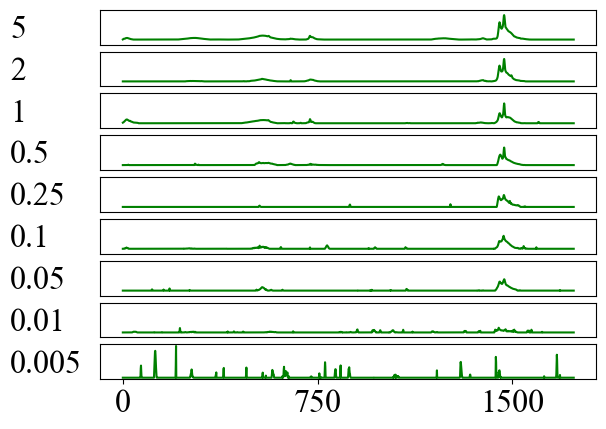

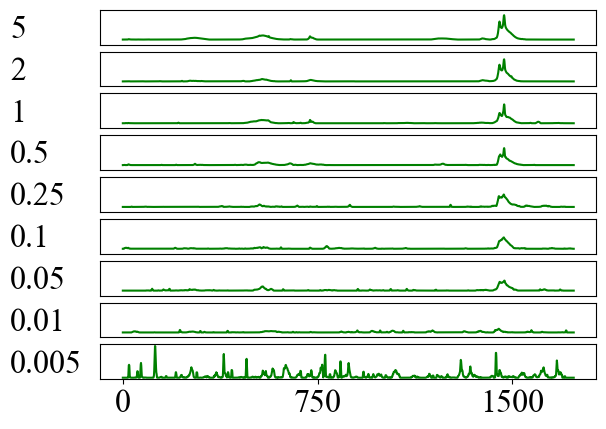

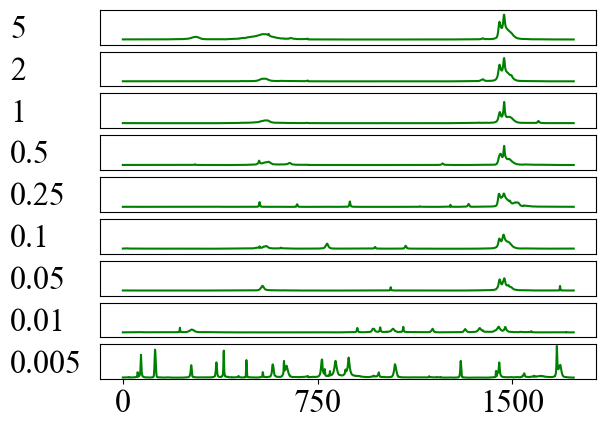

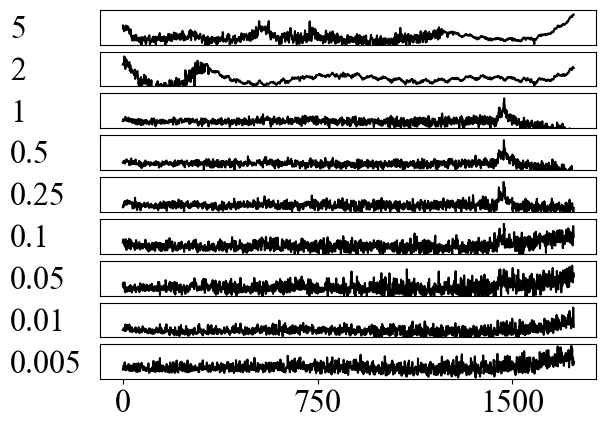

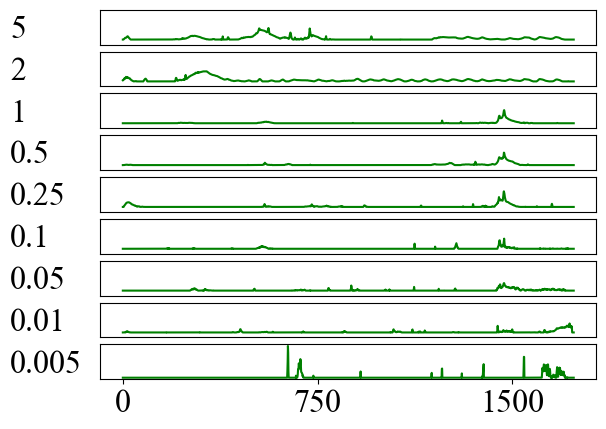

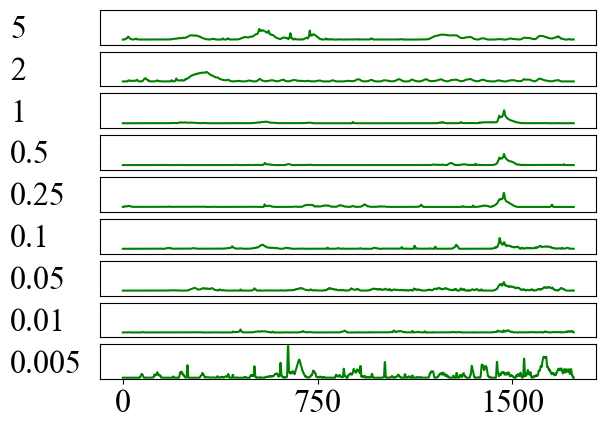

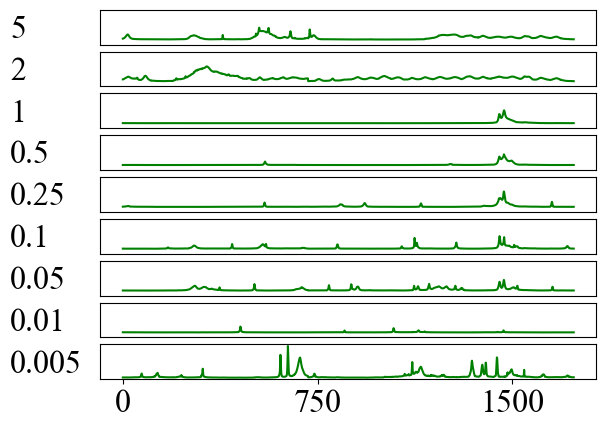

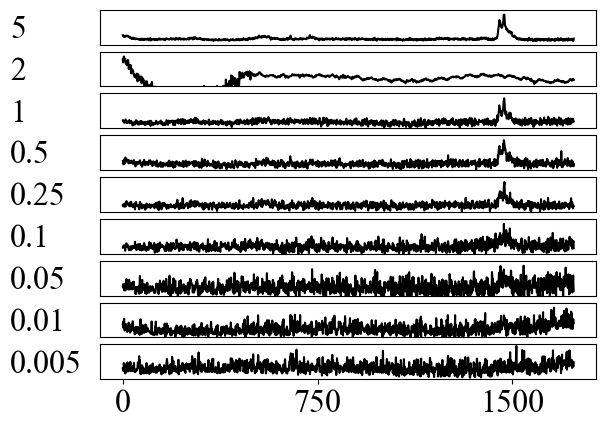

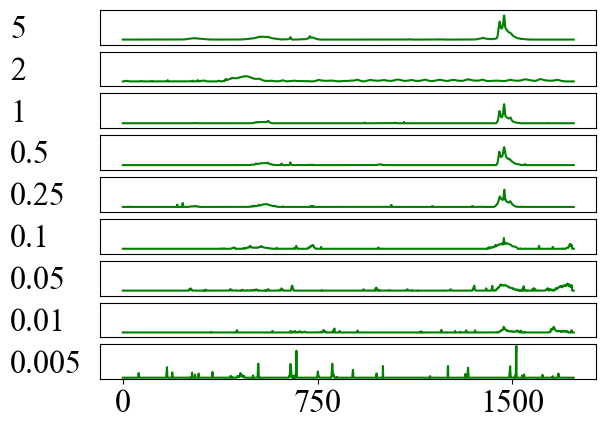

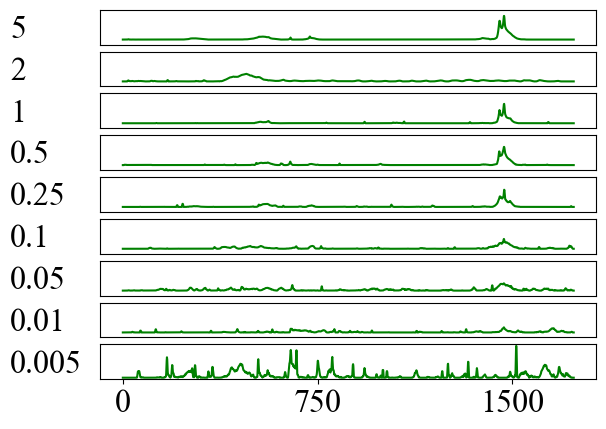

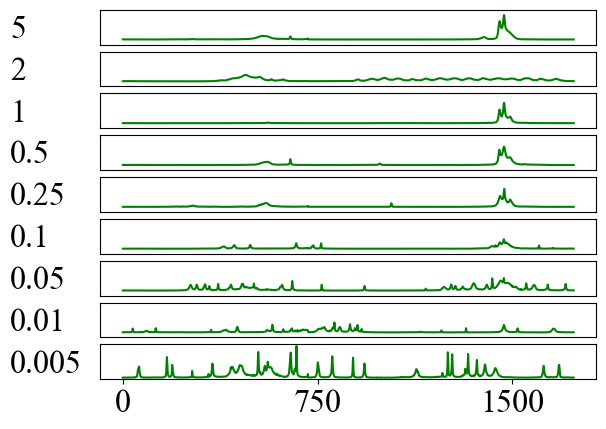

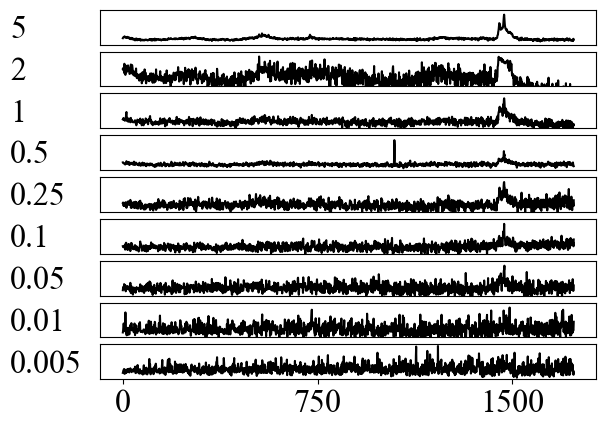

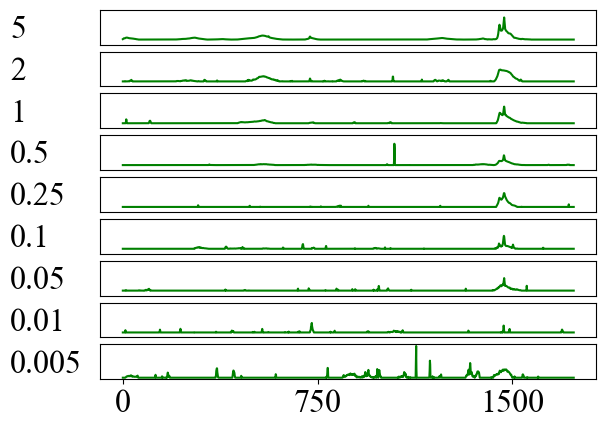

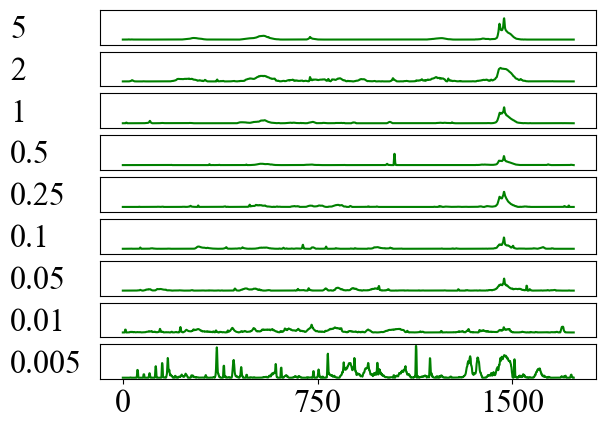

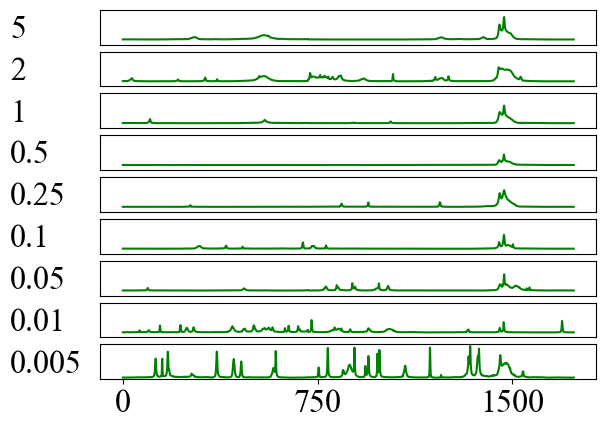

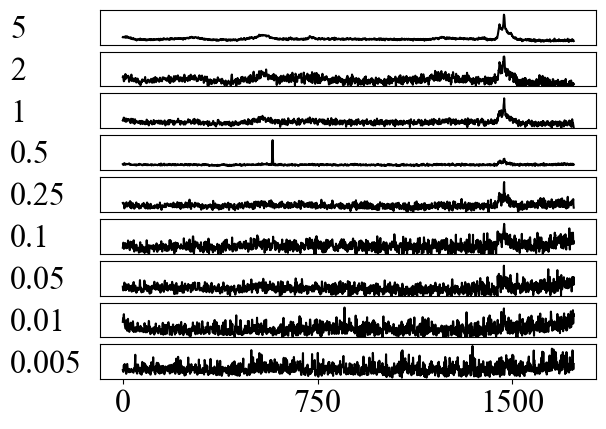

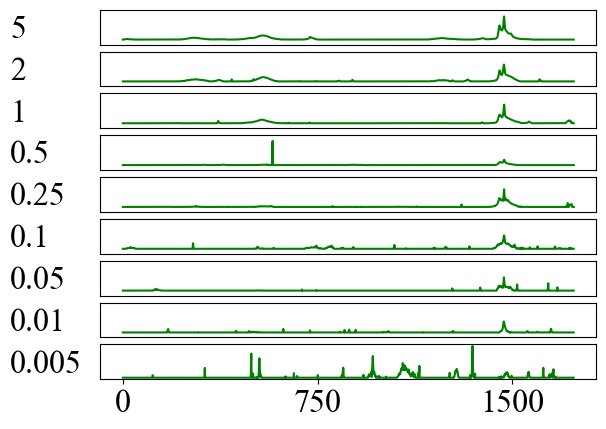

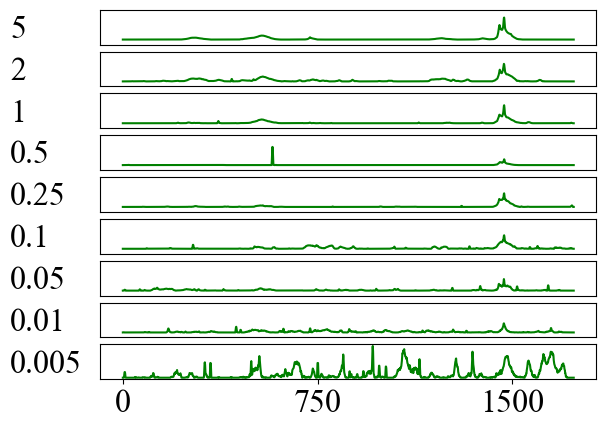

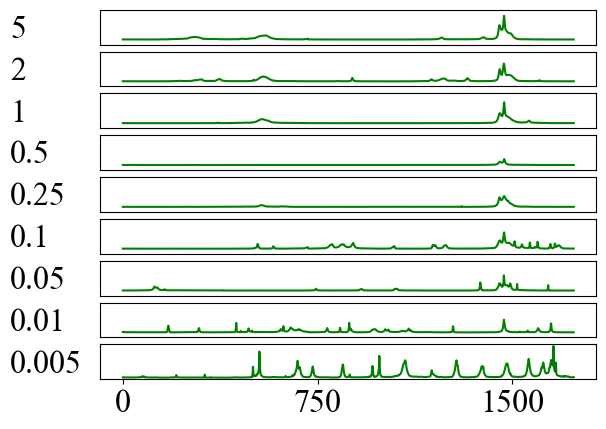

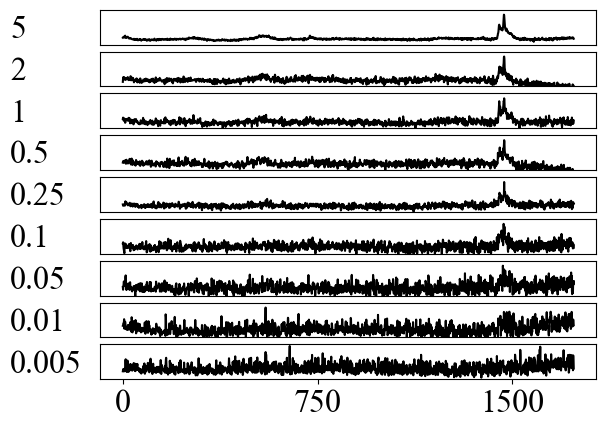

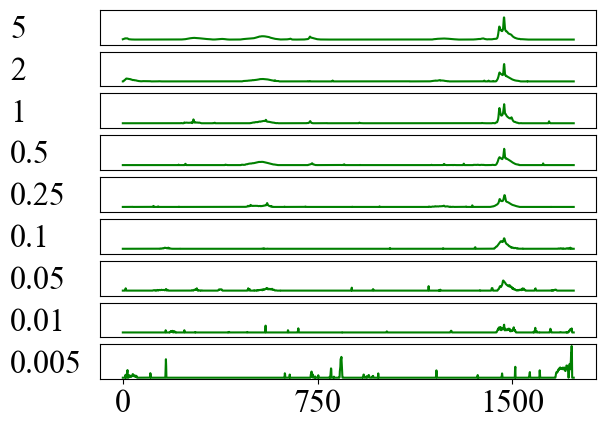

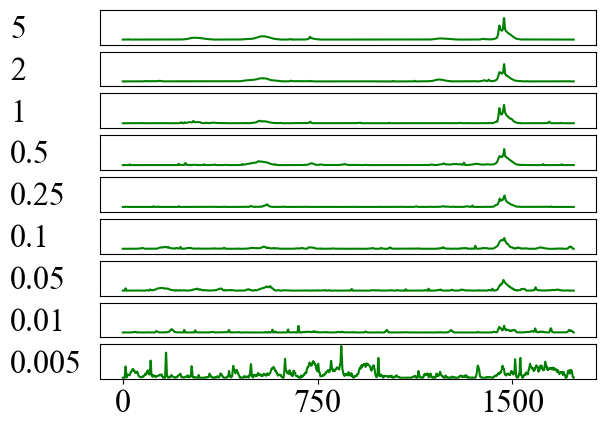

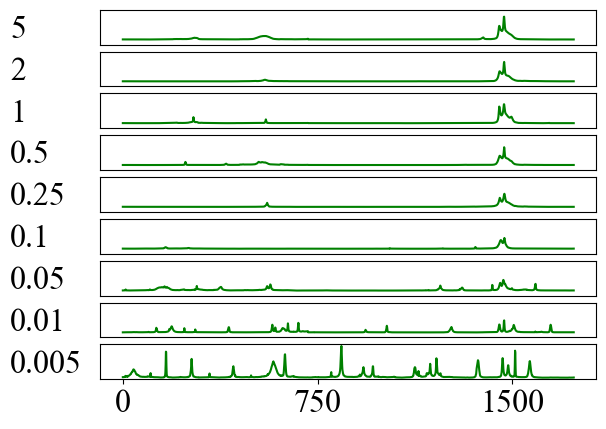

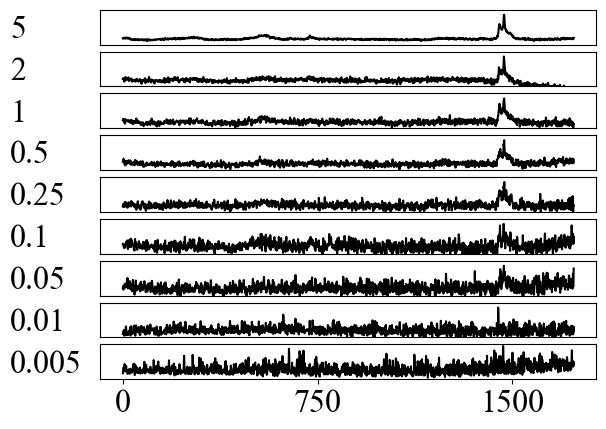

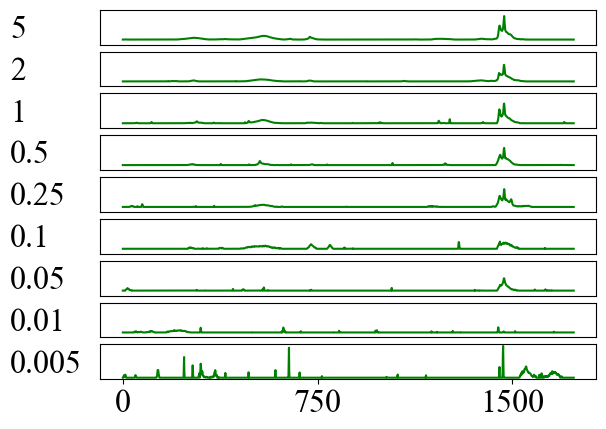

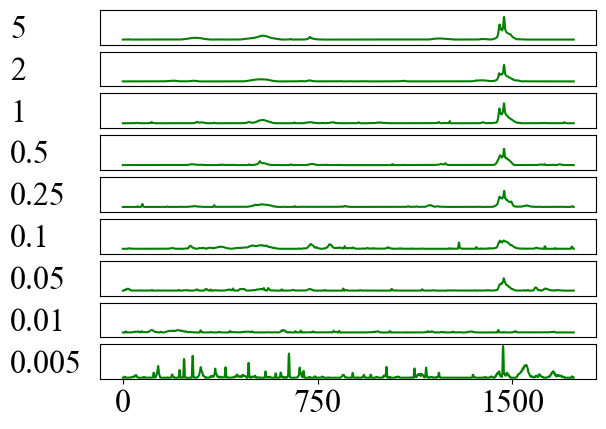

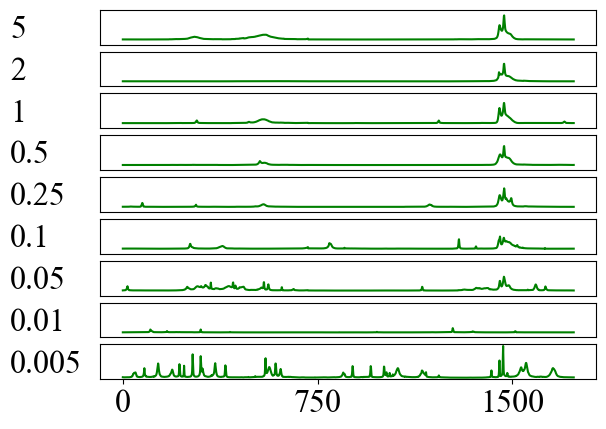

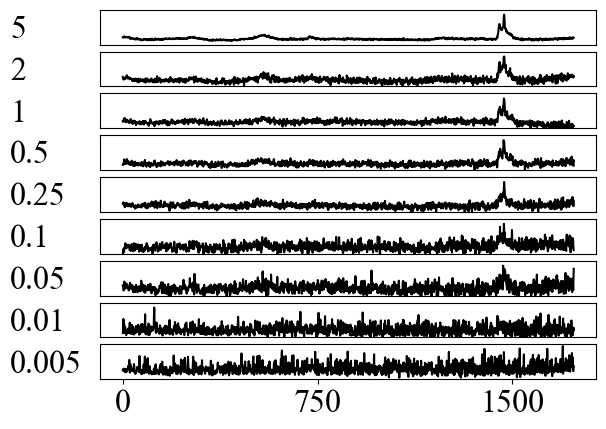

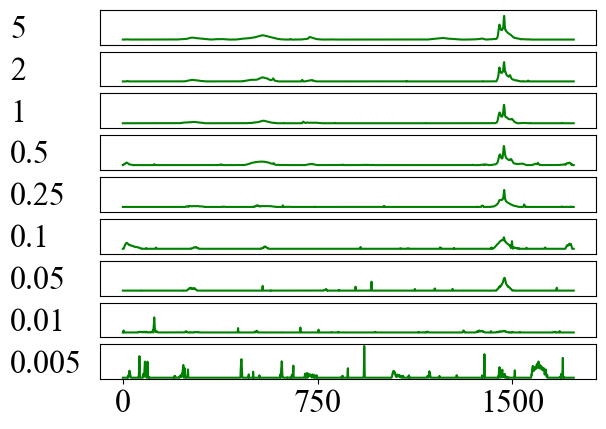

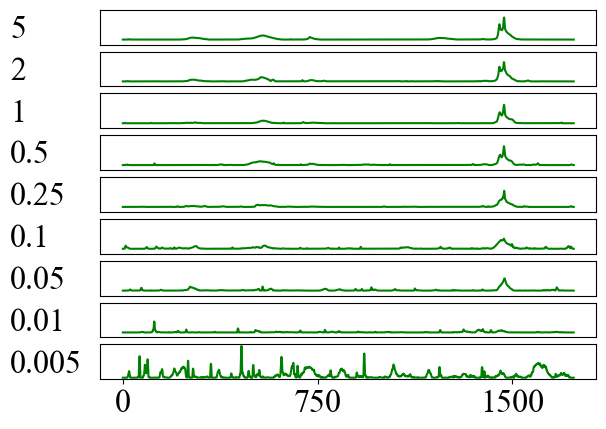

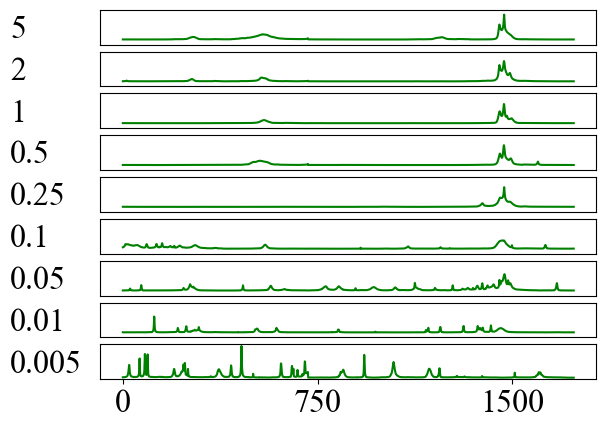

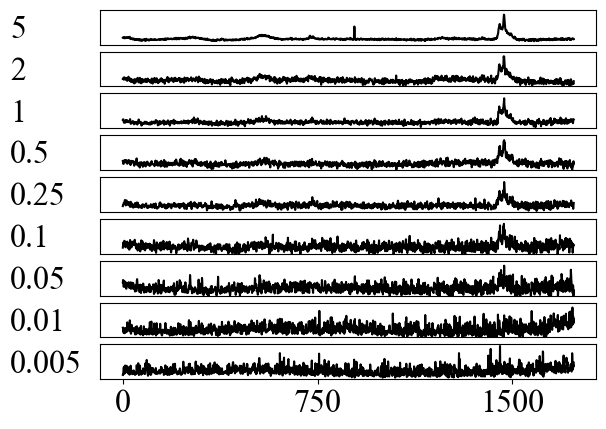

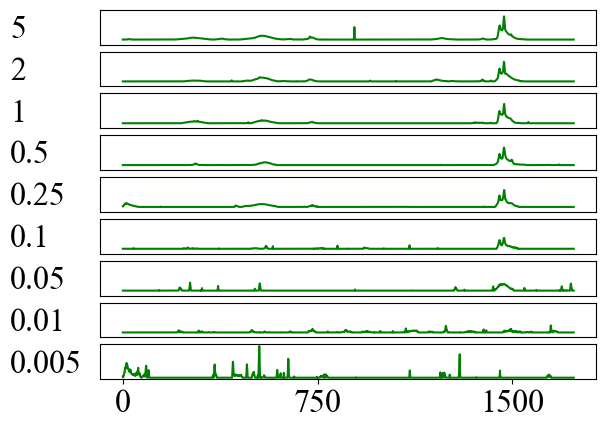

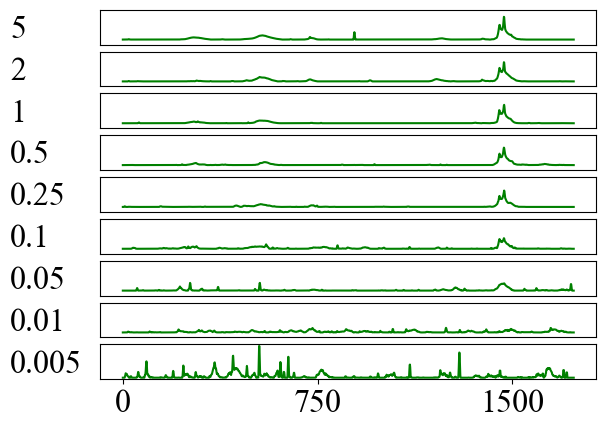

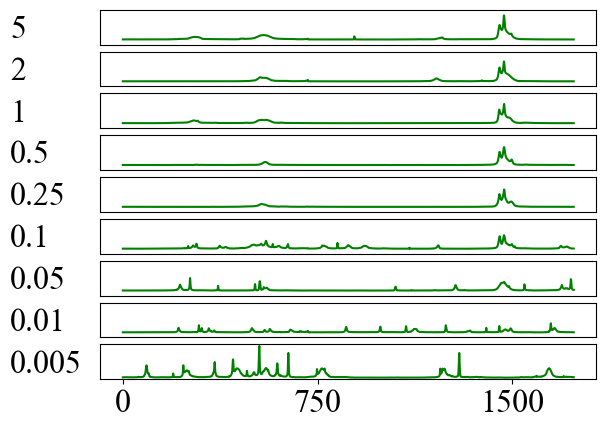

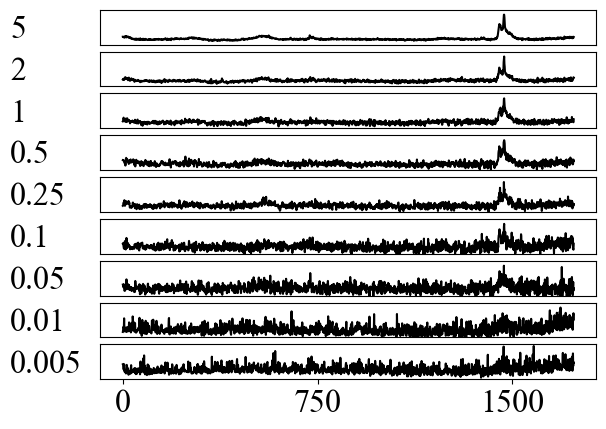

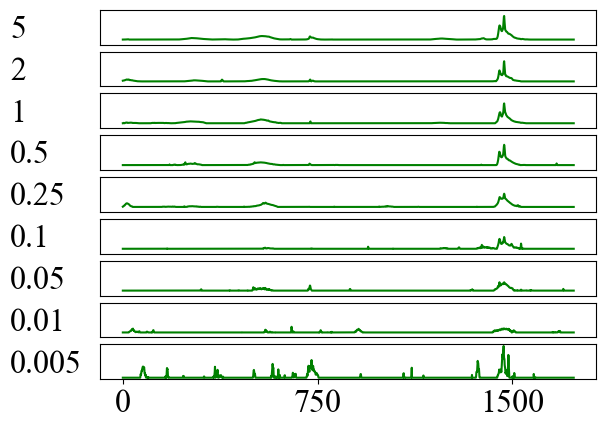

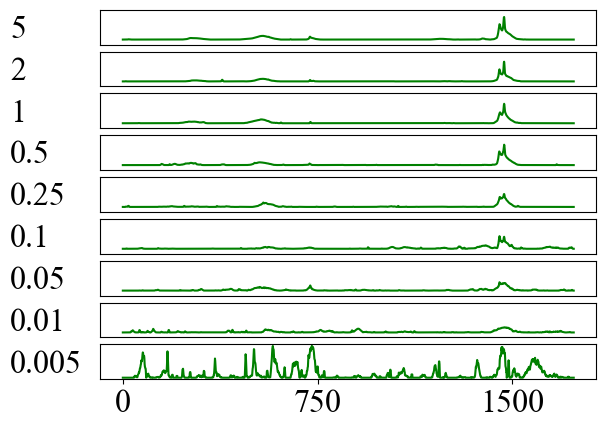

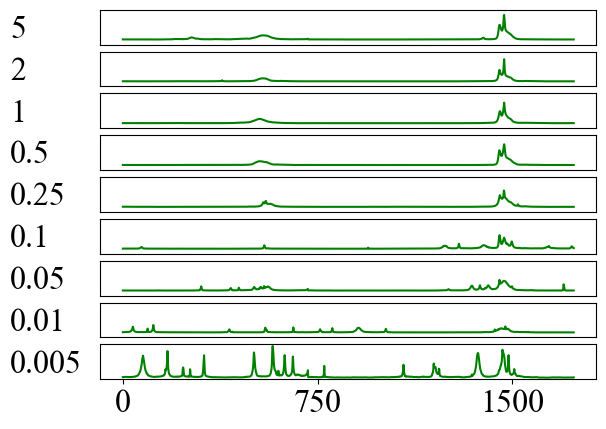

In [7]:
y_labels = []

plt.rcParams.update({'font.size': 23})
plt.rcParams["font.family"] = "Times New Roman"
for y in  data_names:
    y_labels.append(y[9: y.index("s")])

colors = ["Green"]*3

for spectrum in range(20):
    
    # Make a figure showing the different exposure time-spectra serving as input to the models
    fig, axs = plt.subplots(len(data_names), sharex=False, sharey=False)
    
    for en, n in enumerate(np.flip(data_names)):
        dn = np.squeeze(np.copy(data[-(en+1)])).reshape((-1, 1738))
        
        maxim = np.max(dn, axis = 1)
        # Normalize the spectrum such that maximum is 1
        dn = dn/ np.expand_dims(maxim, -1)

        axs[en].plot(dn[spectrum], color = "Black")
        
        axs[en].set_ylabel(np.flip(y_labels)[en], rotation=0, loc='bottom', labelpad=65)
        axs[en].set_xticks([])
        axs[en].set_yticks([])
        axs[en].set_ylim(-0.2, 1.2)
        
    plt.autoscale() 
    plt.xticks([0, 750, 1500])
    plt.savefig("Figures/HF2600Denoising/" + str(spectrum) + "_Input.png",
               bbox_inches='tight', pad_inches=0.75)
    plt.show()
    
    
    names = ["Ensemble", "Standard", "Cascaded"]
    names_ix = 0
    for p, c in zip([ensemble_preds, standard_preds, casc_preds], colors):
        fig, axs = plt.subplots(len(data_names), sharex=False, sharey=False)
        for en, n in enumerate(np.flip(data_names)):

            axs[en].plot(p[n][spectrum], color = c)
            axs[en].set_ylabel(np.flip(y_labels)[en], rotation=0, loc='bottom', labelpad=65)
            axs[en].set_xticks([])
            axs[en].set_yticks([])
            axs[en].set_ylim(-0.2, 1.2)
        plt.autoscale() 

        plt.xticks([0, 750, 1500])
        plt.savefig("Figures/HF2600Denoising/" + str(spectrum) + "_"+names[names_ix]+".png",
                   bbox_inches='tight', pad_inches=0.75)
        names_ix += 1
        plt.show()

In [16]:
names = ["Ensemble", "Standard", "Kazemzadeh et al."]

metrics = []
for data_name, new_target in zip(data_names, targets):
    metrics.append([])
    
    print(data_name)
    names_ix = 0
    for p in [ensemble_preds, standard_preds, casc_preds]:

        ix = new_target > 0.0
        peak_rmse = 1 - np.mean(np.nan_to_num(p[data_name]), axis = 0)[ix]/new_target[ix]
        peak_rmse = np.sqrt(np.mean(np.power(peak_rmse, 2)))
        m = peak_rmse
        #m = np.sqrt(np.mean(np.power(new_target - np.nan_to_num(p[data_name]), 2)))
        maxim = np.max(new_target)
        #m = np.sqrt(np.mean(np.power(new_target/maxim - np.nan_to_num(p[data_name]/maxim), 2)))
        m = np.max(np.abs(new_target/maxim - np.nan_to_num(p[data_name]/maxim)))
        
        print(m)
        metrics[-1].append(m)
        names_ix += 1
    
metrics = np.array(metrics)
exp_times = []
for data_name in data_names:
    t = float(data_name[len("HF2600exp"): len("HF2600exp") + data_name[len("HF2600exp"):].find("s")])
    exp_times.append(t)
exp_times = np.array(exp_times)
sorting = np.argsort(exp_times)

exp_times = exp_times[sorting]
metrics = metrics[sorting]

HF2600exp0.005s25um.h5
5.129205
3.773109
4.7739778
HF2600exp0.01s25um.h5
3.3540196
2.5496671
3.3863358
HF2600exp0.05s25um.h5
1.971593
1.47299
1.5135639
HF2600exp0.1s25um.h5
1.6325709
0.9727943
1.161718
HF2600exp0.25s25um.h5
1.4290454
1.1001407
0.99475884
HF2600exp0.5s25um.h5
1.3166994
1.0883613
0.93443143
HF2600exp1s25um.h5
1.2875305
1.1602877
1.1390164
HF2600exp2s.h5
1.319874
1.2612551
1.1978937
HF2600exp5s.h5
1.1234461
1.1140121
0.9934212


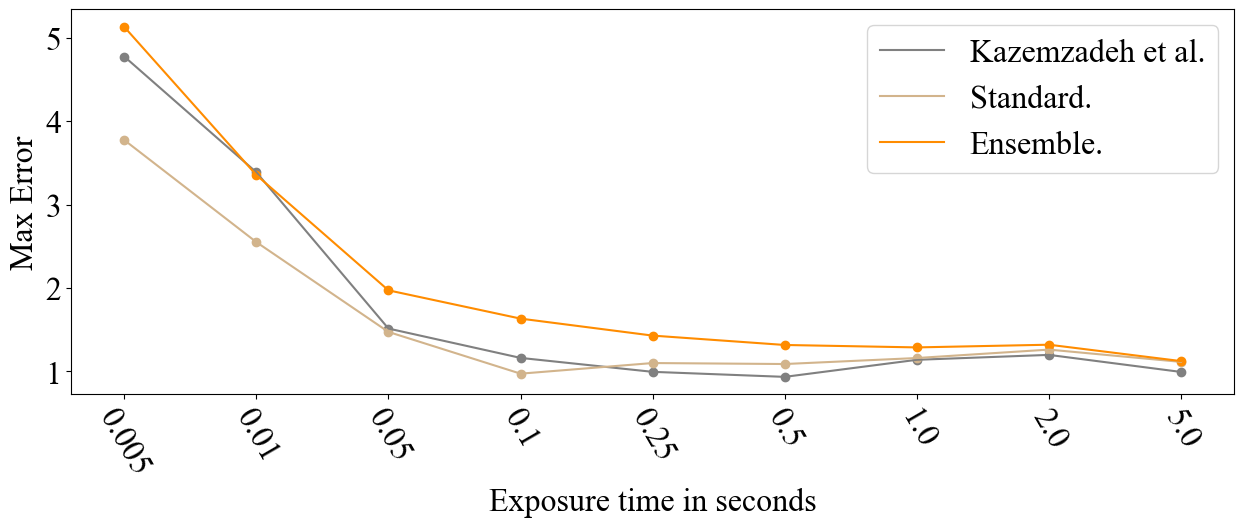

In [19]:
plt.rcParams.update({'font.size': 23})
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(figsize = (15, 5))

plt.plot(metrics[:, 2], color = "gray", label = "Kazemzadeh et al.")
plt.scatter(np.arange(len(metrics)), metrics[:, 2], color = "gray")

plt.plot(metrics[:, 1], color = "tan", label = "Standard.")
plt.scatter(np.arange(len(metrics)), metrics[:, 1], color = "tan")

plt.plot(metrics[:, 0], color = "darkorange", label = "Ensemble.")
plt.scatter(np.arange(len(metrics)), metrics[:, 0], color = "darkorange")

plt.xticks(np.arange(len(exp_times)), exp_times, rotation = -60)

plt.xlabel("Exposure time in seconds")
plt.ylabel("Max Error")
plt.legend()

plt.savefig("Figures/HF2600ExposureTimeReduction.png",
                   bbox_inches='tight', pad_inches=0.75)
plt.show()

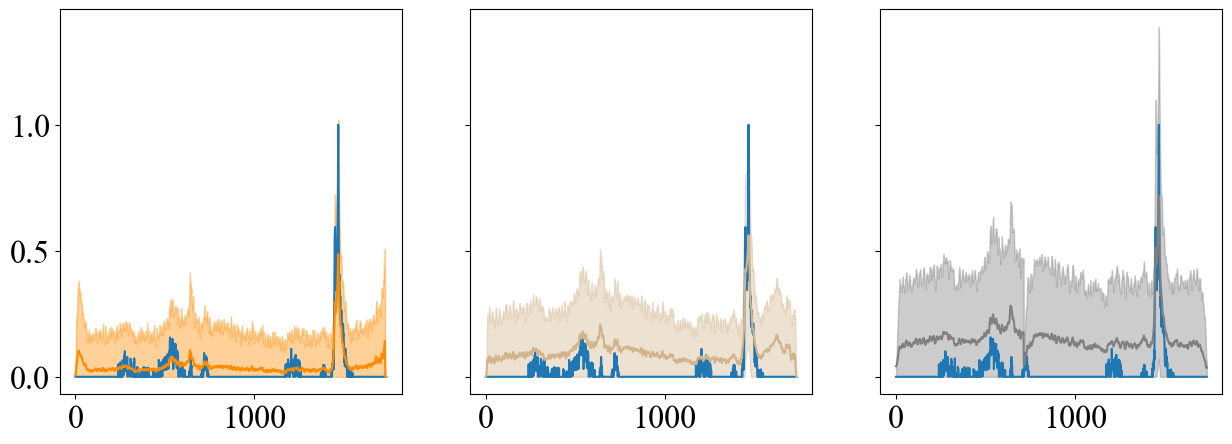

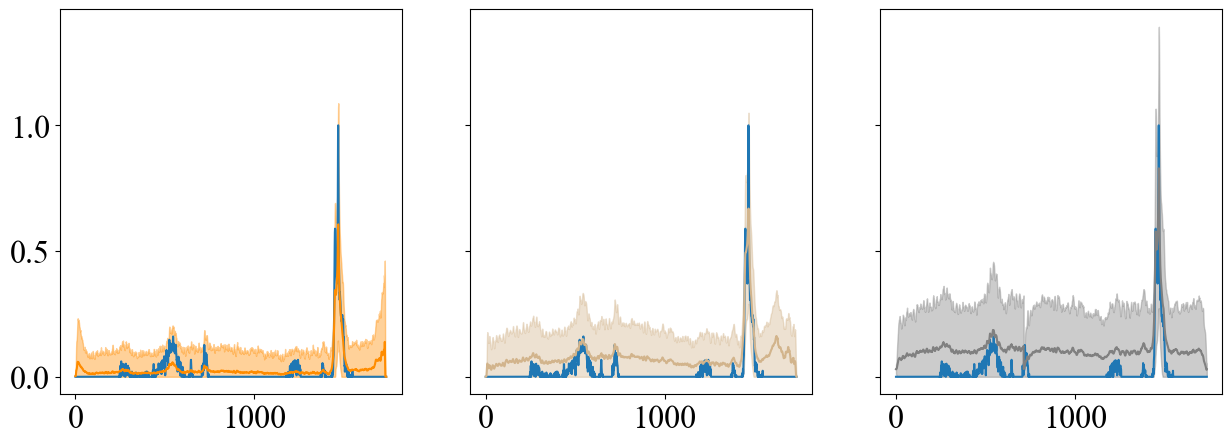

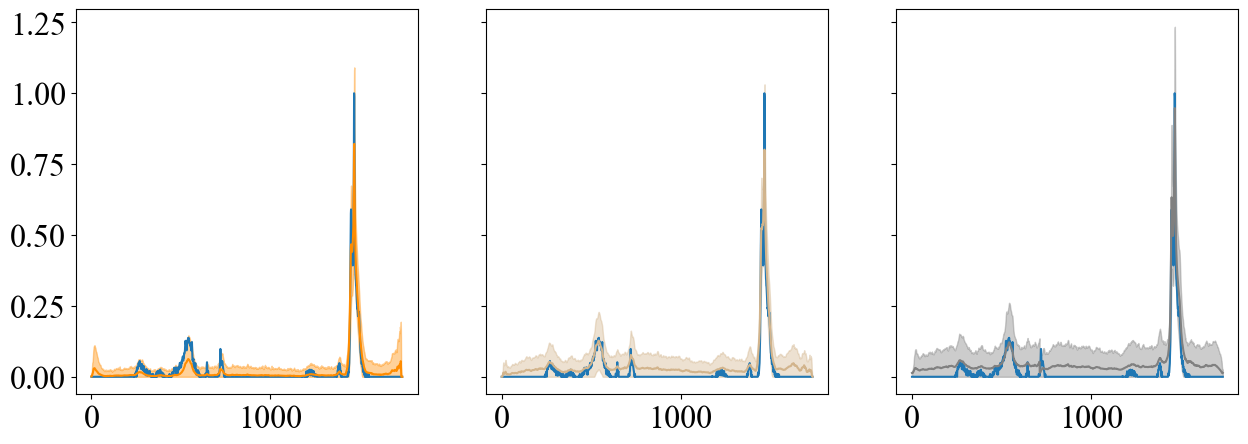

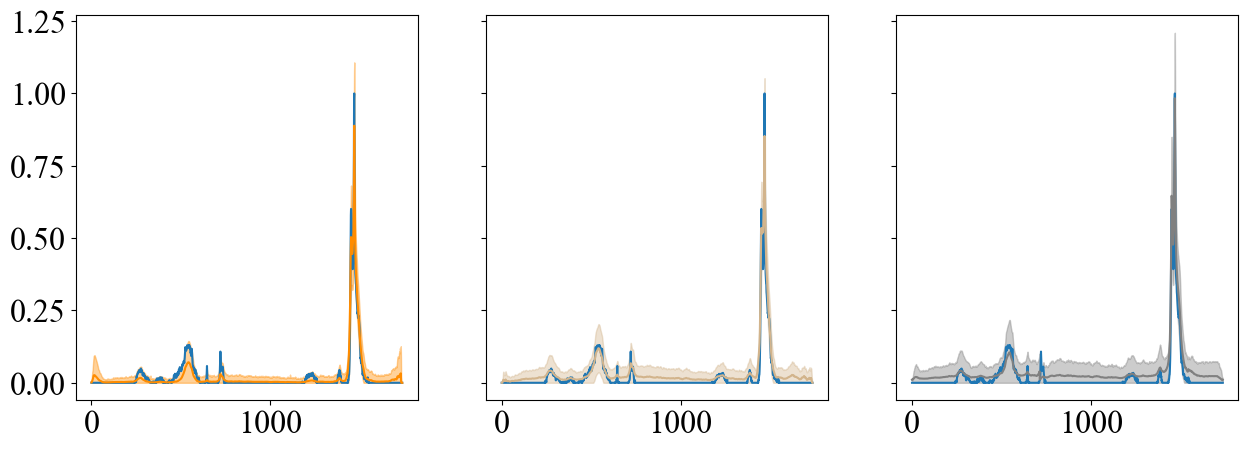

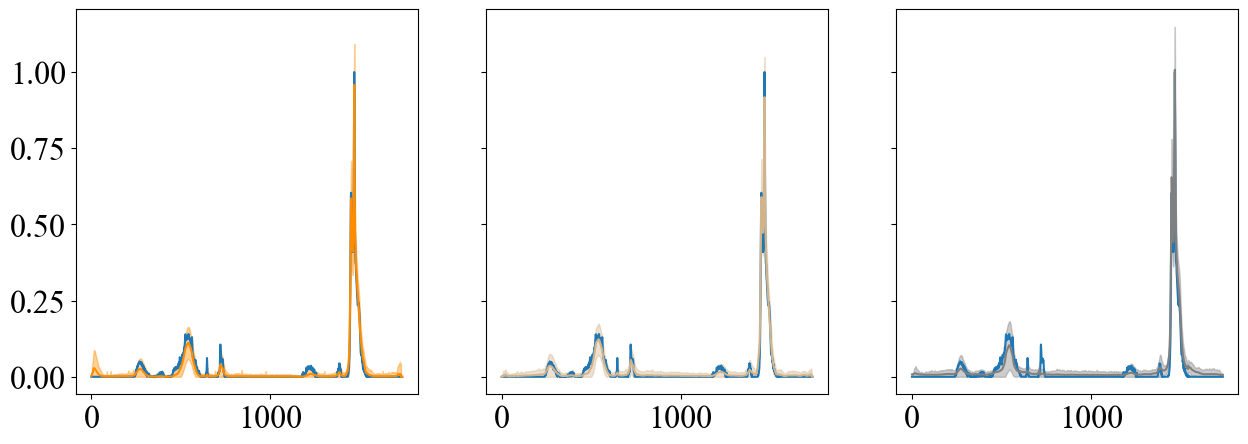

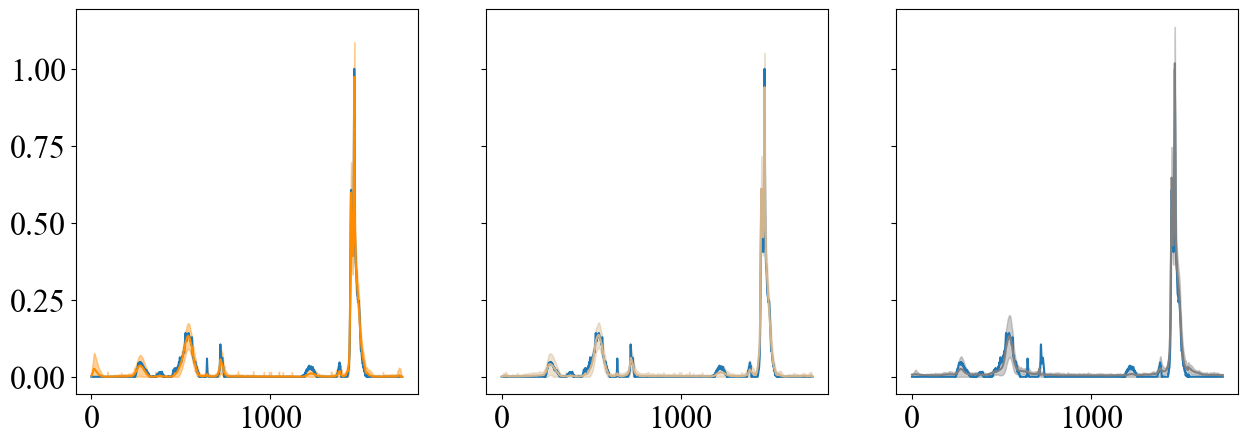

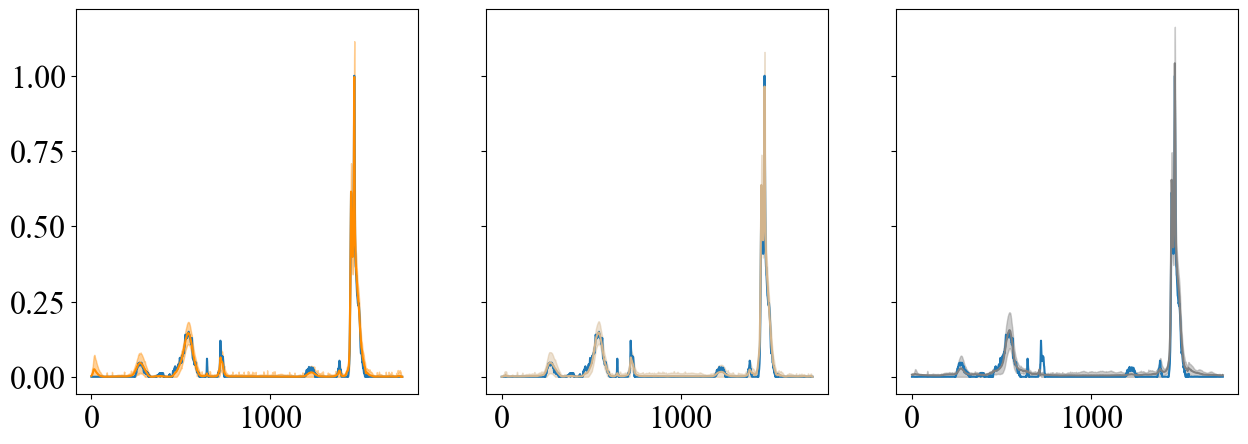

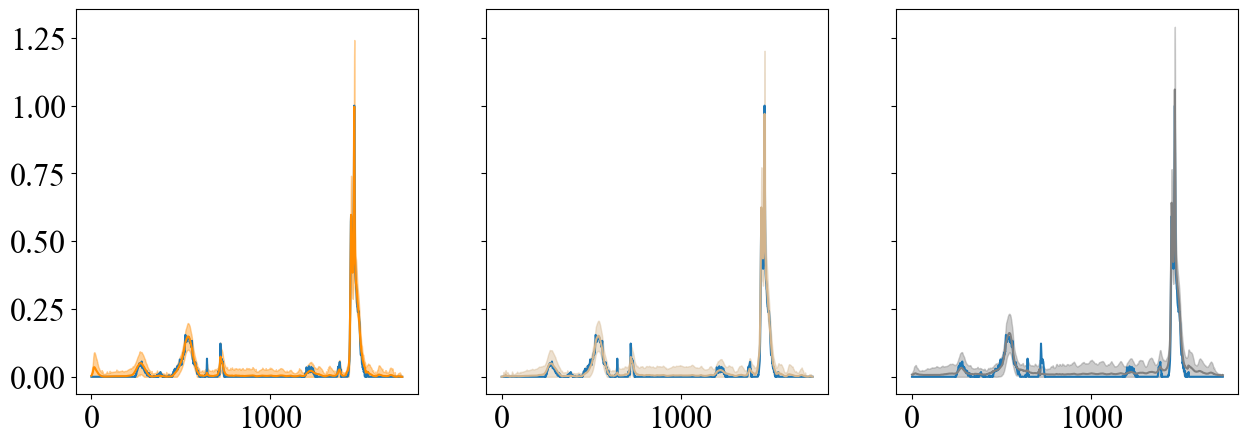

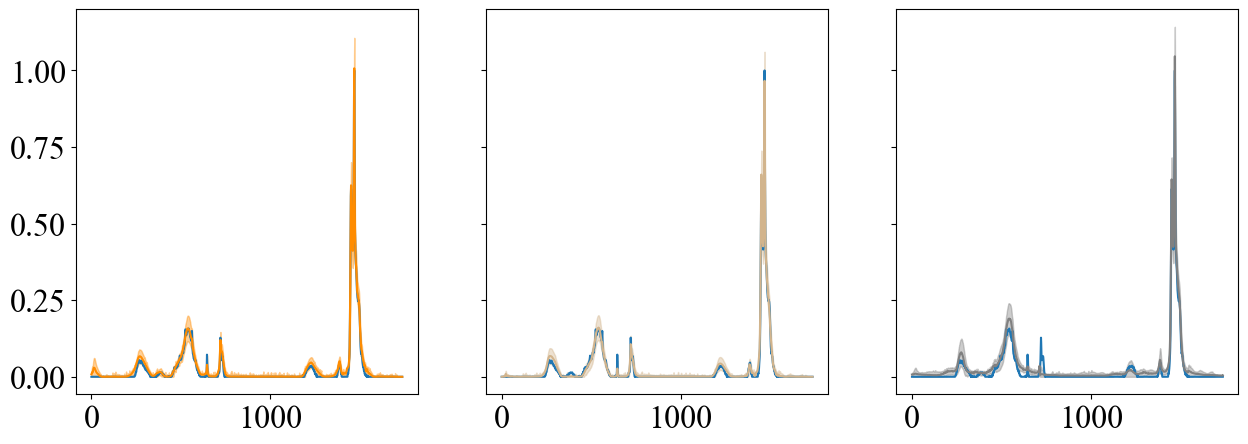

In [10]:
for t, n in zip(targets, data_names):
    
    maxim = np.max(t)
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
    
    ax[0].plot(t/maxim)
    mean = np.mean(ensemble_preds[n]/maxim, axis = 0)
    std = np.std(ensemble_preds[n]/maxim, axis = 0)
    ax[0].fill_between(np.arange(len(mean)), mean + std, np.clip(mean - std, 0, 1), color = "darkorange", alpha = 0.4)
    ax[0].plot(mean, color = "darkorange")

    
    ax[1].plot(t/maxim)
    mean = np.mean(standard_preds[n]/maxim, axis = 0)
    std = np.std(standard_preds[n]/maxim, axis = 0)
    ax[1].fill_between(np.arange(len(mean)), mean + std, np.clip(mean - std, 0, 1), color = "tan", alpha = 0.4)
    ax[1].plot(mean, color = "tan")

    
    ax[2].plot(t/maxim)
    mean = np.mean(casc_preds[n]/maxim, axis = 0)
    std = np.std(casc_preds[n]/maxim, axis = 0)
    ax[2].fill_between(np.arange(len(mean)), mean + std, np.clip(mean - std, 0, 1), color = "gray", alpha = 0.4)
    ax[2].plot(mean, color = "gray")
    #plt.ylim([-0.05, 1.1])
    plt.show()

[294, 384, 519, 644, 724, 1217, 1384, 1489]
HF2600exp0.005s25um.h5
(100, 1738)


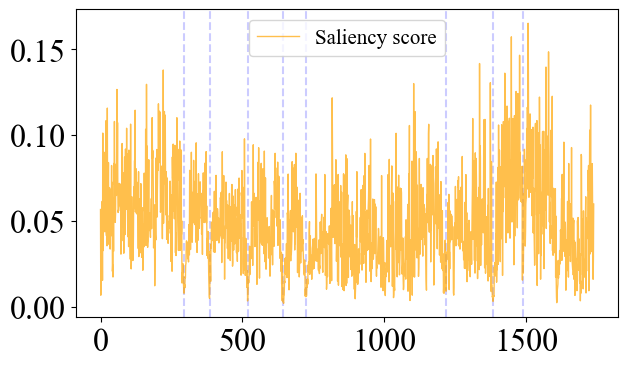

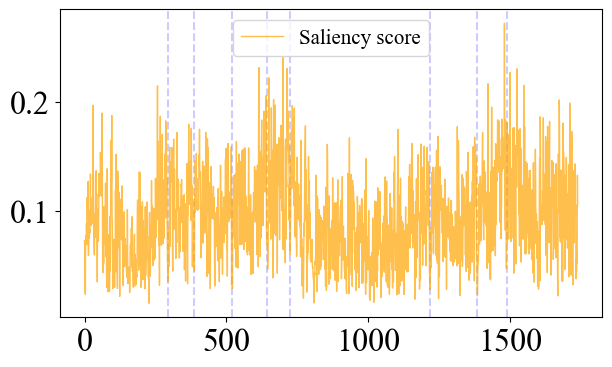

HF2600exp0.01s25um.h5
(100, 1738)


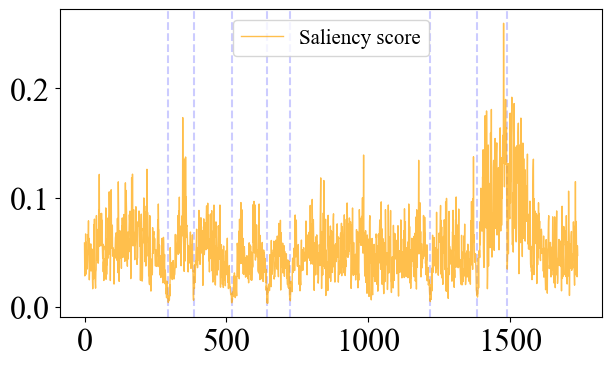

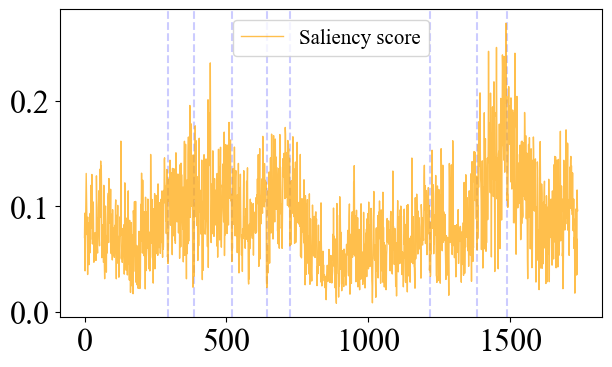

HF2600exp0.05s25um.h5
(100, 1738)


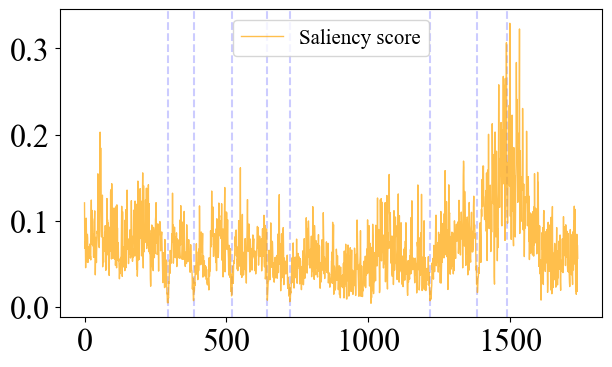

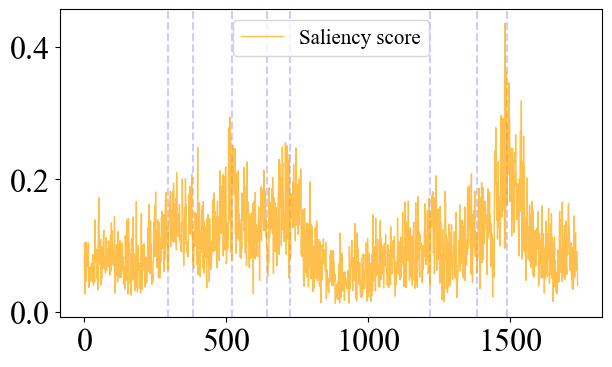

HF2600exp0.1s25um.h5
(100, 1738)


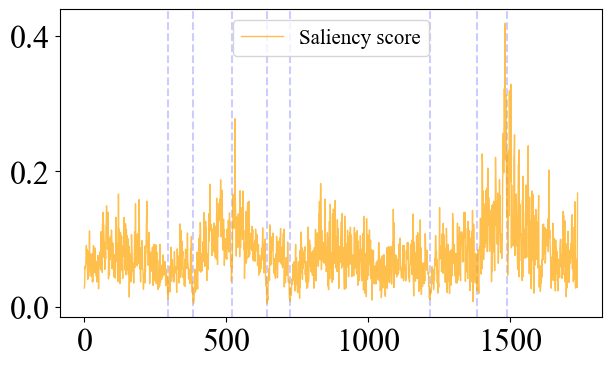

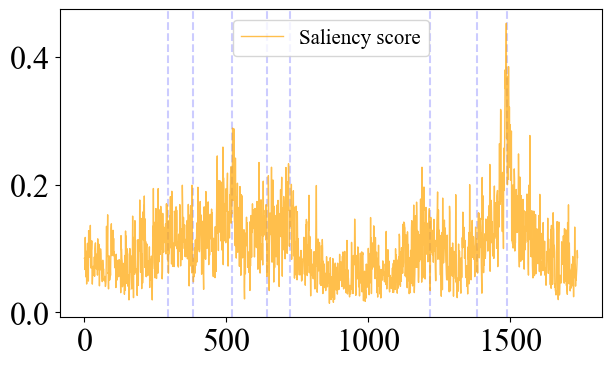

HF2600exp0.25s25um.h5
(100, 1738)


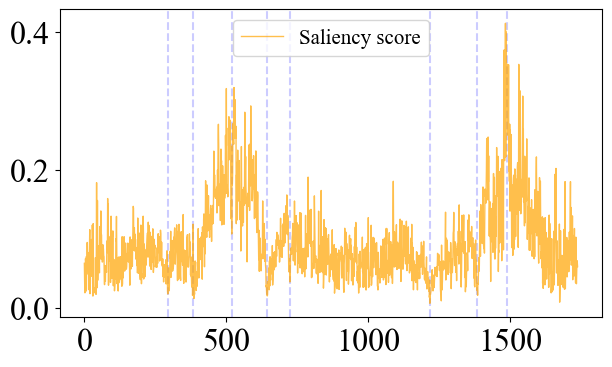

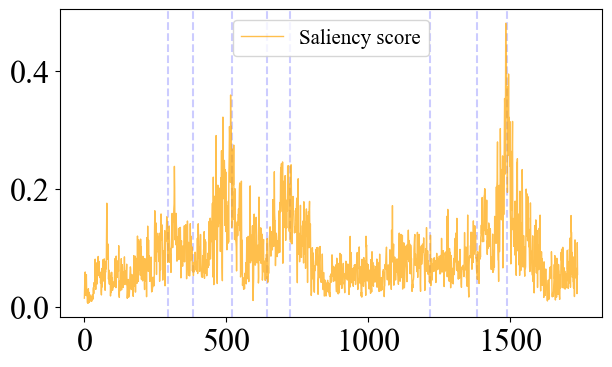

HF2600exp0.5s25um.h5
(100, 1738)


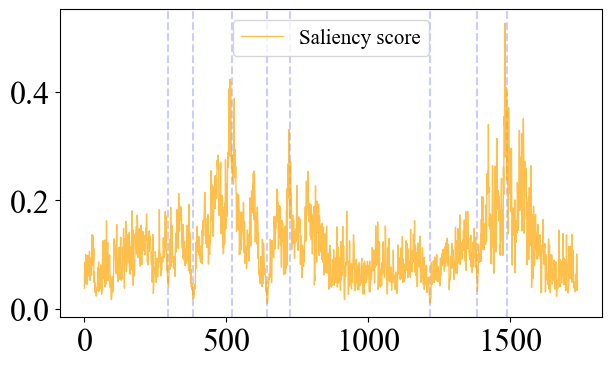

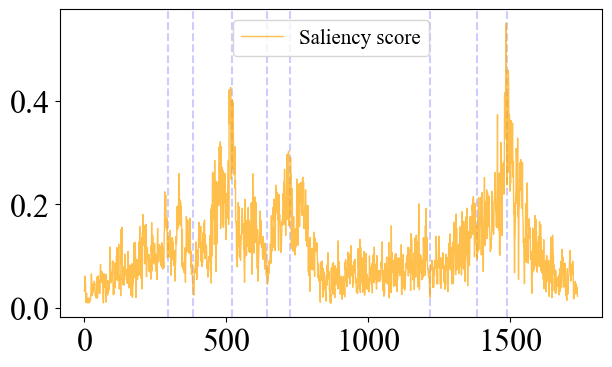

HF2600exp1s25um.h5
(100, 1738)


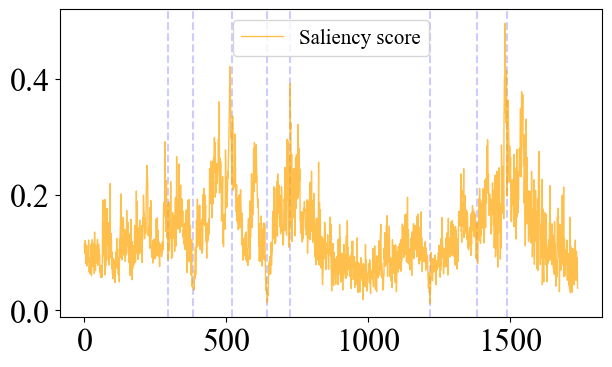

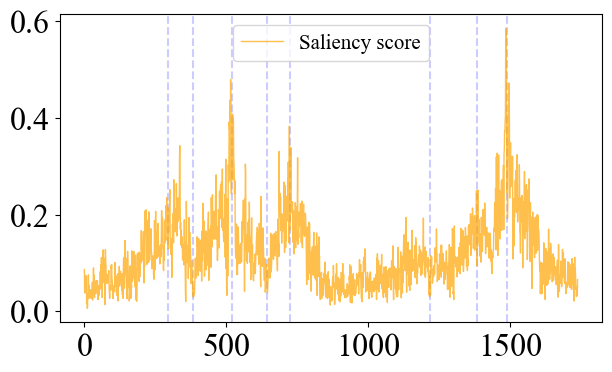

HF2600exp2s.h5
(100, 1738)


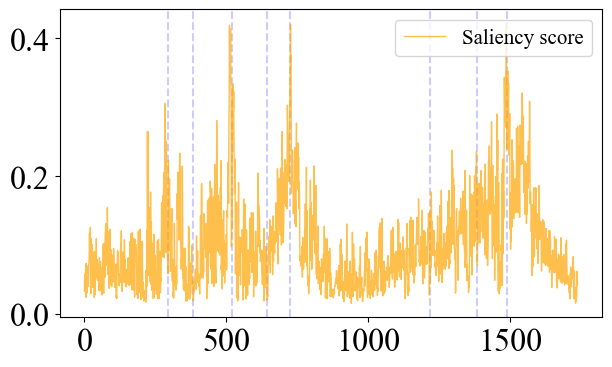

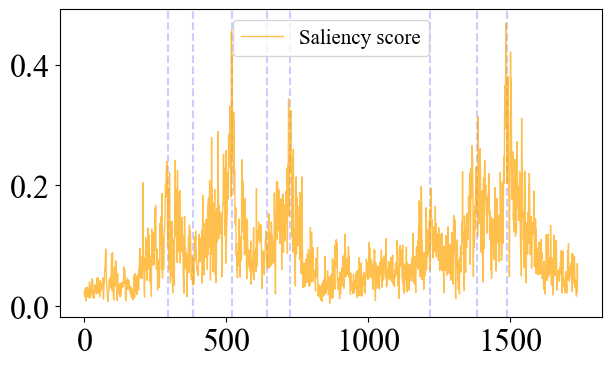

HF2600exp5s.h5
(100, 1738)


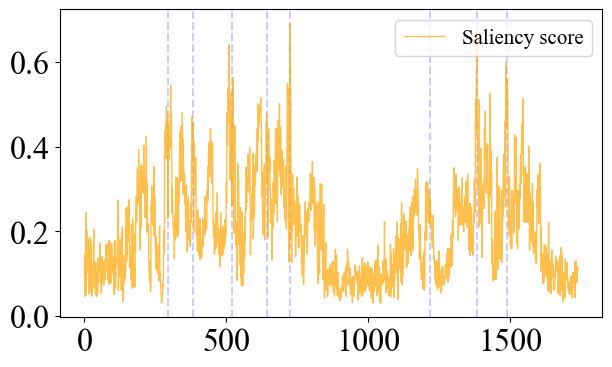

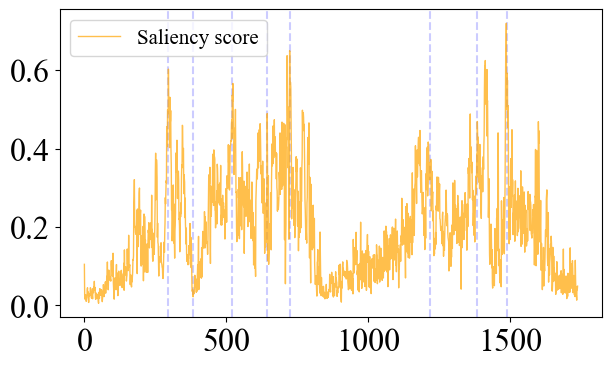

In [4]:
ranges = [[240, 350], [360, 410], [430, 610], [635, 655], [705, 745], [1175, 1260], [1370, 1400], [1430, 1550]]
r_ix = [np.median(np.arange(r[0], r[1])).astype(int) for r in ranges]
print(r_ix)
plt.rcParams.update({'font.size': 23})
plt.rcParams["font.family"] = "Times New Roman"
for d, n in zip(data, data_names):
    print(n)
        
    dn = np.copy(d.reshape((-1, 1738)))

    dn = dn[np.sum(dn, axis = 1) != 0.0]

    inp = tf.constant(dn[:100])

    
    with tf.GradientTape() as tape:
        
        tape.watch(inp)
        result = ensemble_model(inp)[-1]

        grads = tape.gradient(tf.gather(result, r_ix, axis = 1), inp)
        print(grads.numpy().shape)
        out = grads.numpy()
        out = np.median(np.abs(out)/np.max(np.abs(out), axis = 0), axis = 0)
        
        plt.figure(figsize=(7, 4))
        for r in r_ix:
            plt.axvline(r, color = 'b', linestyle = "--", alpha = 0.2)
        plt.plot(np.squeeze(out), alpha = 0.7, linewidth = 1, color = "Orange", label = "Saliency score")
        plt.legend(fontsize = 15)
        plt.savefig("Figures/HF2600SalMap_ensemble_" + n +".png", transparent = True,
                   bbox_inches='tight', pad_inches=0.75)
        plt.show()


    with tf.GradientTape() as tape:
        
        tape.watch(inp)
        result = standard_model(inp)[-1]

        grads = tape.gradient(tf.gather(result, r_ix, axis = 1), inp)
        out = grads.numpy()
        out = np.median(np.abs(out)/np.max(np.abs(out), axis = 0), axis = 0)
        
        plt.figure(figsize=(7, 4))
        #plt.plot(dn[0], alpha = 0.2, linestyle = "--", linewidth = 1, color = "Black", label = "Input")
        for r in r_ix:
            plt.axvline(r, color = 'b', linestyle = "--", alpha = 0.2)
        plt.plot(np.squeeze(out), alpha = 0.7, linewidth = 1, color = "Orange", label = "Saliency score")
        
        plt.legend(fontsize = 15)
        plt.savefig("Figures/HF2600SalMap_standard_" + n +".png", transparent = True,
                   bbox_inches='tight', pad_inches=0.75)
        plt.show()
    

[294, 384, 519, 644, 724, 1217, 1384, 1489]
HF2600exp5s.h5


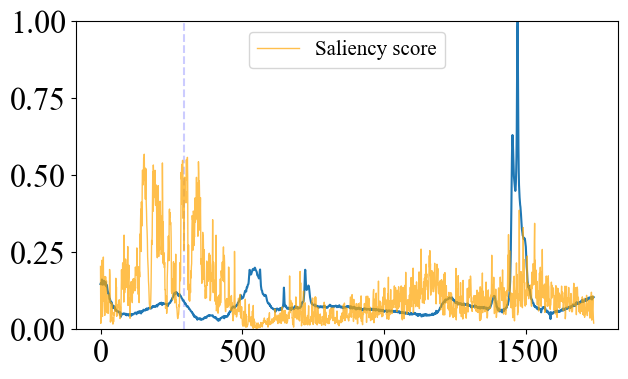

ResourceExhaustedError: {{function_node __wrapped__Conv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[100,1738,12,10] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput]

In [5]:
ranges = [[240, 350], [360, 410], [430, 610], [635, 655], [705, 745], [1175, 1260], [1370, 1400], [1430, 1550]]
r_ix = [np.median(np.arange(r[0], r[1])).astype(int) for r in ranges]
print(r_ix)
plt.rcParams.update({'font.size': 23})
plt.rcParams["font.family"] = "Times New Roman"
if True:
#for d, n in zip(data, data_names):
    d = data[-1]
    n = data_names[-1]
    print(n)
        
    dn = np.copy(d.reshape((-1, 1738)))

    dn = dn[np.sum(dn, axis = 1) != 0.0]

    inp = tf.constant(np.nan_to_num(dn[:100]))

    
    
        
        
        
    for i in r_ix:
        with tf.GradientTape() as tape:
            tape.watch(inp)
            result = ensemble_model(inp)[-1]
            grads = tape.gradient(tf.gather(result, [i], axis = 1), inp)

            out = grads.numpy()
            out = np.median(np.abs(out)/np.max(np.abs(out), axis = 0), axis = 0)
            
            plt.figure(figsize=(7, 4))
            plt.axvline(i, color = 'b', linestyle = "--", alpha = 0.2)
            plt.plot(np.median(dn, axis = 0))
            plt.plot(np.squeeze(out), alpha = 0.7, linewidth = 1, color = "Orange", label = "Saliency score")
            plt.ylim([0, 1])
            plt.legend(fontsize = 15)
            #plt.savefig("Figures/HF2600SalMap_ensemble_" + n +".png", transparent = True,
            #           bbox_inches='tight', pad_inches=0.75)
            plt.show()


    
        
        

    for i in r_ix:
        with tf.GradientTape() as tape:
            tape.watch(inp)
            result = standard_model(inp)[-1]
            grads = tape.gradient(tf.gather(result, [i], axis = 1), inp)

            out = grads.numpy()
            out = np.median(np.abs(out)/np.max(np.abs(out), axis = 0), axis = 0)
            
            plt.figure(figsize=(7, 4))
            plt.axvline(i, color = 'b', linestyle = "--", alpha = 0.2)
            plt.plot(np.median(dn, axis = 0))
            plt.plot(np.squeeze(out), alpha = 0.7, linewidth = 1, color = "Orange", label = "Saliency score")
            plt.ylim([0, 1])
            plt.legend(fontsize = 15)
            #plt.savefig("Figures/HF2600SalMap_ensemble_" + n +".png", transparent = True,
            #           bbox_inches='tight', pad_inches=0.75)
            plt.show()
    